In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from ironsilicate import IronSilicateEOS
from scipy import interpolate
from scipy import integrate

This reads the PhotometryPlanetRadiiSamplesRedo.csv file that I generated in USPRadiusDistribution.ipynb. It has 1000 radius samples for each USP planet. I make them all into a giant 62000-sample list that I can then slice for each planet.

In [3]:
periodsamples = []
radiisamples = []
kepids = []
meanearthradii = []
radiierrup = []
radiierrdown = []
per = []

## get 1000 planetary radius samples per planet, set up period array
with open('PhotometryPlanetRadiiSamplesRedo2.csv') as File:
    reader = csv.reader(File, delimiter=',')
    rownum = 0
    for row in reader:
        kepids.append(int(row[0]))
        samplelist = list(str(row[1]).split(','))
        samplelist[0] = samplelist[0][1:] # remove brackets
        samplelist[len(samplelist)-1] = samplelist[len(samplelist)-1][:-1] #remove brackets
        sampleslist = [float(i) for i in samplelist]
        meanearthradii.append(np.percentile(sampleslist, 50))
        ##earthradiierr.append(np.std(sampleslist))
        radiierrup.append(np.percentile(sampleslist, 15.85))
        radiierrdown.append(np.percentile(sampleslist, 84.15))
        radiisamples = radiisamples + sampleslist
        rownum += 1


In [4]:
print(len(kepids))
print(len(radiisamples))
print(meanearthradii)

62
62000
[1.4828595214497735, 1.1417693178784196, 1.299602052048148, 1.2494126410326891, 1.341555274362875, 1.4497973697926798, 1.367525658991736, 1.177115662137026, 1.4287650565338335, 1.197758706026557, 1.4376423448906706, 1.3748607503885488, 1.1964126286545085, 1.2054772586114626, 1.6777120973437811, 1.6381244702566227, 1.5085035078126272, 1.7523962699831843, 1.3771860868897927, 1.475721288556048, 1.138500652331357, 1.6502240500806409, 1.7370626082246239, 1.2965043359286446, 1.5480695353675142, 1.477953578818641, 1.1504360775718523, 0.9003409149640466, 0.9089832591243384, 1.5604521351254783, 1.103815423874319, 1.3077422209468512, 0.9698880580395954, 2.4109850247728475, 1.138400668552263, 1.8770164760504073, 1.164840204369851, 0.9024679748976583, 1.03228908387961, 1.4759154079466923, 0.7288173208418447, 1.3628332005798844, 1.506315265073694, 1.7119929460058647, 1.5804141723308331, 1.3537724881845694, 1.2649077618273505, 1.700772739537351, 1.7218430914569, 1.4392047108330575, 1.266630

Set up spherical integration

# Spherical Integration

In [5]:
G = 6.67e-11
epsilon = 0.00001

Emass = 5.972e24 ## Earth mass
Erad = 6371000 ## Earth radius

P_cmb = np.logspace(8., 14., 32)
P_max_hat = np.logspace(0., 2., 32)


cmfarray = np.zeros((len(P_cmb), len(P_max_hat)))
crfarray = np.zeros_like(cmfarray)
planetmass = np.zeros_like(cmfarray)
planetrad = np.zeros_like(cmfarray)

In [6]:
Pcarr = []
rhos = []

for i in range(len(P_cmb)):
    for j in range(1, len(P_cmb)):
        
        Pcmb = P_cmb[i]
        eos = IronSilicateEOS(Pcmb, P_max_hat[j])
        Pc = eos.P_max
        Pcarr.append(Pc)
        
        def rho(P):
            return eos.eqnOfState(P)
        
        
        m0 = (4/3) * np.pi * rho(Pc) * (epsilon**3) ## initial mass
        P0 = Pc - (2/3) * np.pi * G * (rho(Pc)**2) * (epsilon**2) ## initial pressure
        
         ## change of variables where q = ln(P)
        def dmdq(q, m, r):
            P = np.exp(q)
            g = (G * m) / (r**2)
            return (-4 * P * np.pi * (r**2)) / g
        
        def drdq(q, m, r):
            P = np.exp(q)
            g = (G * m) / (r**2)
            return -P / (rho(P) * g)
            
        def fun(q, x):
            m, r = x
            return dmdq(q, m, r), drdq(q, m, r)
        
        q0 = np.log(P0)
        
        sol = integrate.solve_ivp(fun, t_span = (q0, 0), y0 = [m0, epsilon], method = 'LSODA', rtol = 0.5e-3, atol = 0.5e-6, max_step = .1)

        ## LSODA is the only integration method that works for this order of magnitude
        
        pressure = np.exp(sol.t)
        masses = sol.y[0]
        radii = sol.y[1]
        
        if i == 25 and j == 25:
             pre = np.exp(sol.t)
             mas = sol.y[0]
             rad = sol.y[1]
        
        

        # interpolate masses
        s = interpolate.interp1d(pressure, masses)
        coremass = s(Pcmb) # mass of core
        totalmass = s(1) # total planet mass
        cmf = coremass / totalmass # core mass fraction
        cmfarray[i][j] = cmf
        planetmass[i][j] = totalmass / Emass # in Earth masses
        
        # interpolate radii
        r = interpolate.interp1d(pressure, radii)
        corerad = r(Pcmb) # radius of core
        totalrad = r(1) # total radius
        crf = corerad / totalrad # core radius fraction
        crfarray[i][j] = crf
        planetrad[i][j] = totalrad / Erad # in Earth radii


Set up and flatten arrays for interpolation

In [7]:
Pcmbarray = np.zeros((len(P_cmb), len(P_cmb)))
Pmaxhatarray = np.zeros((len(P_cmb), len(P_cmb)))
for i in range(len(P_cmb)):
    for j in range(len(P_cmb)):
        Pcmbarray[i][j] = P_cmb[i]
        Pmaxhatarray[i][j] = P_max_hat[j]

In [8]:
flatrad = planetrad.flatten()
flatcmf = cmfarray.flatten()
flatPcmb = Pcmbarray.flatten()
flatPmaxhat = Pmaxhatarray.flatten()

getpcmb = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPcmb)
getpmaxhat = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPmaxhat)

getmass = interpolate.RegularGridInterpolator((P_cmb, P_max_hat), planetmass)

Interpolate massses. If the interpolation doesn't work for a sample, I put in a placeholder to maintain the order when slicing.

In [9]:
np.random.normal(0.33,0.1)

0.44944654196426514

In [10]:
earthmasssamples = []
i = 0
for radsample in radiisamples:
    try:
        earthmasssamples.append(getmass((getpcmb(radsample, 0.33), getpmaxhat(radsample, 0.33))))
        i = i + 1
    except:
        print("could not interpolate for sample", i)
        earthmasssamples.append(np.nan)
        i = i + 1

print("Mercury")
count = 0
mercurymasssamples = []
i = 0
for radsample in radiisamples:
    try:
        mercurymasssamples.append(getmass((getpcmb(radsample, 0.7), getpmaxhat(radsample, 0.7))))
        i = i + 1
    except:
        print("could not interpolate for sample", i)
        count += 1
        mercurymasssamples.append(np.nan)
        i = i + 1
    
        
randmasssamples = []
i = 0
for radsample in radiisamples:
    randomcmf = np.random.normal(0.33,0.1)
    while (randomcmf <= 0):
        randomcmf = np.random.normal(0.33,0.1)
    try:
        randmasssamples.append(getmass((getpcmb(radsample, randomcmf), getpmaxhat(radsample, randomcmf))))
        i = i + 1
    except:
        print("could not interpolate for sample", i, "cmf = ", randomcmf)
        randmasssamples.append(np.nan)
        i = i + 1

print(count)

Mercury
could not interpolate for sample 33024
could not interpolate for sample 33029
could not interpolate for sample 33047
could not interpolate for sample 33142
could not interpolate for sample 33143
could not interpolate for sample 33171
could not interpolate for sample 33195
could not interpolate for sample 33240
could not interpolate for sample 33277
could not interpolate for sample 33319
could not interpolate for sample 33400
could not interpolate for sample 33415
could not interpolate for sample 33430
could not interpolate for sample 33436
could not interpolate for sample 33443
could not interpolate for sample 33467
could not interpolate for sample 33512
could not interpolate for sample 33547
could not interpolate for sample 33561
could not interpolate for sample 33573
could not interpolate for sample 33602
could not interpolate for sample 33644
could not interpolate for sample 33696
could not interpolate for sample 33700
could not interpolate for sample 33727
could not interpo

In [11]:
print(kepids[33])
print(len(randmasssamples))
print(len(mercurymasssamples))

8895758
62000
62000


In [12]:
meanearthmasses = []
eartherr = []
eartherrup = []
eartherrdown = []

meanmercmasses = []
mercerr = []
mercerrup = []
mercerrdown = []

meanrandmasses = []
randerr = []
randerrup = []
randerrdown = []


file = open('EarthlikeMassSamples.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, (len(earthmasssamples) // 1000)):
        list1 = []
        list1 = earthmasssamples[(1000*i) : (1000*(i+1)) - 1]
        for f in list1:
            if np.isnan(f):
                list1.remove(f)
                print("removed")
        meanearthmasses.append(np.percentile(list1, 50))
        eartherr.append(np.std(list1))
        eartherrup.append(np.percentile(list1, 15.85))
        eartherrdown.append(np.percentile(list1, 84.15))
        row = [kepids[i]]
        for k in range(0, len(list1)):
            row.append(list1[k])
        writer.writerow(row)
        
count = 0
file = open('MercuryLikeMassSamples.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, (len(mercurymasssamples) // 1000)):
        list1 = []
        list1 = mercurymasssamples[(1000*i) : (1000*(i+1)) - 1]
        for f in list1:
            if np.isnan(f):
                list1.remove(f)
                count += 1
                print("removed")
        meanmercmasses.append(np.percentile(list1, 50))
        mercerrup.append(np.percentile(list1, 15.85))
        mercerrdown.append(np.percentile(list1, 84.15))
        mercerr.append(np.std(list1))
        row = [kepids[i]]
        for k in range(0, len(list1)):
            row.append(list1[k])
        writer.writerow(row)
        ##print(i)
        
file = open('RandomCMFMassSamples.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, (len(randmasssamples) // 1000)):
        list1 = []
        list1 = randmasssamples[(1000*i) : (1000*(i+1)) - 1]
        for f in list1:
            if np.isnan(f):
                list1.remove(f)
                print("removed")
        meanrandmasses.append(np.percentile(list1, 50))
        randerrup.append(np.percentile(list1, 15.85))
        randerrdown.append(np.percentile(list1, 84.15))
        randerr.append(np.std(list1))
        row = [kepids[i]]
        for k in range(0, len(list1)):
            row.append(list1[k])
        writer.writerow(row)
        
print(count)

removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed


/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
34


In [13]:
print(meanmercmasses)

[6.783658339835074, 2.514625459287655, 4.054361979649752, 3.552569379771298, 4.640067676420764, 6.215871676395129, 5.002750695799228, 2.8268360512995905, 5.951792954255794, 3.0357984831217126, 6.063884404938335, 5.117530124600816, 3.0235258328613717, 3.109722411725609, 11.374738124631909, 10.19479014928401, 7.306490115598811, 13.521326882271643, 5.155232817449441, 6.648572230537914, 2.4932450766119723, 10.557328139799283, 13.085723233377976, 4.024468624928613, 8.163917385411494, 6.692439547797676, 2.5706965481333386, 1.0687187621115515, 1.1121897211427763, 8.431601817701592, 2.2440983772081995, 4.153318650026964, 1.406486705887822, nan, 2.4925600364209712, 18.396070239931667, 2.7050582071546305, 1.0797619111362469, 1.7487700348951316, 6.647255582689252, 0.5102550710249725, 4.9312129915838305, 7.259876470893989, 12.378902188456804, 8.86438389782556, 4.8033768381787745, 3.7178095684379837, 12.061845591476182, 12.657217737177836, 6.08564375463818, 3.7358846129457817, 1.73693776747214, 13.

In [14]:
print(eartherrup)

[3.160506685430703, 1.4836839381066373, 2.417768235790845, 2.2018036642860497, 2.4678660206502903, 3.266136562649007, 2.6964389109374354, 1.5168799617053756, 3.5519377510341763, 1.7105752530606475, 3.388774023224226, 3.111783871942734, 1.8432803777823508, 1.6384739589513018, 6.05534468400341, 5.679492929771847, 4.368157208418457, 7.614346825153816, 2.9611558241540226, 3.580545205485767, 1.4440193138201145, 4.906504709137234, 6.883991492038332, 2.5182658349215092, 4.563812348591227, 4.103218467131933, 1.535265913941176, 0.5042614377972685, 0.6277008808623772, 4.552874410316898, 1.237169277502689, 1.892735557903098, 0.8190698031951397, 11.924005900379617, 1.4426371185084474, 9.198863400571122, 1.636692557784568, 0.6848936245208296, 0.9077713982660928, 3.67595075493176, 0.3219649778215685, 2.4666924033809585, 4.390968659875562, 6.916811814548536, 5.199657527457143, 2.6031544131028355, 2.017631924738663, 6.684911549480258, 7.435277428526472, 3.584156103902036, 2.273060856401815, 1.06179117

In [15]:
meanplanradband = [1.5142207897134599, 1.1436702581725311, 1.29995494508817, 1.3189668428623589, 1.2269233123544596, 1.3416469177901493, 1.4501086309196631, 1.1346210885160928, 1.3678308145394535, 1.1773182912719149, 1.4290130565850703, 1.1924524835284092, 1.4377185513117101, 1.3778832575370645, 1.1987523431558333, 1.2031537496435152, 1.6789372289268041, 1.6367597521676016, 1.5102166858962964, 1.2450243555135487, 1.7554218547394591, 1.3750204896572571, 1.4763165953082957, 1.1374076117298841, 1.6579424766739201, 1.7474079535815623, 1.2976710643762763, 1.5469721327227073, 1.4803792515077325, 1.1485935543428036, 0.91107113014034191, 0.90912534283711122, 1.5575626745682334, 1.1016976539308982, 1.306567461499029, 0.97216101853985515, 2.3659198651407789, 1.1388767324032376, 1.8878774237581295, 1.1603625846498211, 0.90433911227498831, 1.0330717061012351, 1.4773091465919181, 0.72919497667200817, 1.3558223565388077, 1.5039103713589141, 1.7185699399360876, 1.5759094919342289, 1.3535027097987864, 1.2676025968602689, 1.6999474483312145, 1.7232645141015186, 1.4375272444998766, 1.2675926110963895, 1.0322004078256348, 1.742165191417018, 1.5358602614962091, 1.4630747310708188, 1.3776544531211727, 1.0864475036950445, 1.2169836268301546, 1.4158706344921796, 1.025515766195459, 2.5964514405645982, 0.98803480896675566, 1.3933339279057437, 1.7206936810871374, 1.5010015006680679, 1.4465641351682894, 1.0878734373223826, 1.5076561842415757]

radsss = []
massss = []
cmfsss = []

for i in range(len(planetrad[0])):
    for j in range(len(planetrad)):
        radsss.append(planetrad[i][j])
        massss.append(planetmass[i][j])
        cmfsss.append(cmfarray[i][j])

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


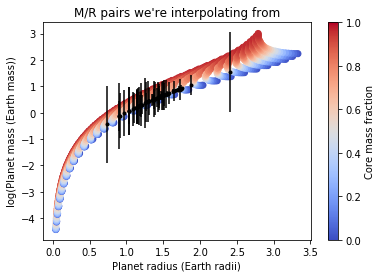

In [16]:
cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(radsss, np.log10(massss), c = cmfsss, vmin = 0., vmax = 1., cmap = cm)
plt.plot(meanearthradii, np.log10(meanearthmasses),'k.')
plt.errorbar(meanearthradii, np.log10(meanearthmasses),ls= 'none',yerr = np.log10(eartherr), ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("log(Planet mass (Earth mass))")
plt.title("M/R pairs we're interpolating from")
plt.show()

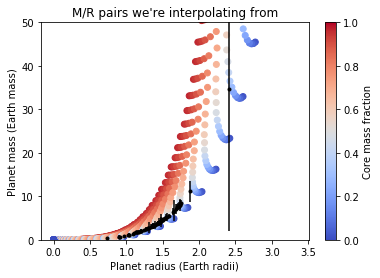

In [17]:
cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(radsss, massss, c = cmfsss, vmin = 0., vmax = 1., cmap = cm)
plt.plot(meanearthradii, meanearthmasses,'k.')
plt.errorbar(meanearthradii, meanearthmasses, ls= 'none',yerr = eartherr, ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("Planet mass (Earth mass)")
plt.title("M/R pairs we're interpolating from")
plt.ylim(0, 50)
plt.show()

In [18]:
kepids.index(11600889)

50

In [19]:
print(meanearthmasses[50])
print(eartherrup[50])
print(eartherrdown[50])

2.461440618486861
2.273060856401815
2.6343548832752433


In [20]:
kepid = []
koi = []
adivr = []
per = []
starrad = []
pradii = []
numstars = []


with open('USPHostProperties.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         if rownum > 0:
             kepid.append(int(row[0]))
             koi.append(int(row[1]))
             adivr.append(float(row[2]))
             per.append(float(row[3]))
             starrad.append(float(row[11]))
             pradii.append(float(row[12]))
             numstars.append(float(row[13]))
         rownum += 1

falsepositives = [4929299, 10527135, 5642620, 12170648, 3834322,6750902,7269881,10186945,12115188]

todelete = []
for j in range(0,len(falsepositives)):
    for i in range(0, len(kepid)):
        if kepid[i] == falsepositives[j]:
            todelete.append(i)
            
todelete.reverse()
for k in todelete:
    del kepid[k]
    del koi[k]
    del per[k]
    del adivr[k]
    del numstars[k]
    
adivr = [adivr[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
per = [per[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
numstars = [numstars[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
print(len(per))
print(len(numstars))

periodsamples = []
for i in range(0, len(radiisamples)):
    periodsamples.append(per[i//1000])
    
print(len(periodsamples))

62
62
62000


In [21]:
import seaborn as sns

radbins = [0.5,(1/np.sqrt(2)),1,np.sqrt(2),2,2*np.sqrt(2),4]
radbinsflip = np.flip(radbins,0) ## makes orientation correct on y axis

perbins = [4,4*(6**0.25),4*np.sqrt(6),4*(6**0.75),24]
array = np.zeros((len(radbins)-1,len(perbins)-1))
scaledarray = np.zeros((len(radbins)-1,len(perbins)-1))
freqarray = np.zeros((len(radbins)-1,len(perbins)-1))

## calculates occurrence rate contribution for each planet sample
f = [(adivr[i]/numstars[i]) for i in range(0,len(kepid))]

kepid2 = []

for i in range(len(periodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(radbins)-1):
            if (perbins[j] <= 24*periodsamples[i] <= perbins[j+1]) and (radbinsflip[k] >= radiisamples[i] >= radbinsflip[k+1]):
                array[k][j] += (f[per.index(periodsamples[i])])/1000
                freqarray[k][j] += 1

print(array * 1000) ## number of planets per 1000 stars
print(freqarray)

for j in range(0,len(perbins)-1):
    for i in range(0,len(radbins)-1):
        if array[i][j] != 0:
            scaledarray[i][j] = 1 + (np.log10(array[i][j]/(5*(10**-9)))) # moved up by 1 to make way for zero.
        if array[i][j] == 0:
            scaledarray[i][j] = 1 + -1
        
print(scaledarray)

## convert period to hours
per2 = [24 * i for i in per]

f2 = [(1/numstars[i]) for i in range(0,len(kepid))]

transitarray = np.zeros((len(radbins)-1,len(perbins)-1))

for i in range(len(periodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(radbins)-1):
            if (perbins[j] <= 24*periodsamples[i] <= perbins[j+1]) and (radbinsflip[k] >= radiisamples[i] >= radbinsflip[k+1]):
                transitarray[k][j] += (f2[per.index(periodsamples[i])])/1000

## calculate 68.3% Wilson Confidence Interval
wilsonhigh = np.empty((len(radbins)-1,len(perbins)-1), dtype = object)
wilsonlow = np.empty((len(radbins)-1,len(perbins)-1), dtype = object)
wilson3d = np.empty((len(radbins)-1,len(perbins)-1,2))
for i in range(len(radbins)-1):
    for j in range(len(perbins)-1):
        if transitarray[i][j] == 0:
            wilsonhigh[i][j] = "N=0"
            wilsonlow[i][j] = "N=0"
        else:
            n = (freqarray[i][j])/(transitarray[i][j])
            if n == 0:
                wilsonhigh[i][j] = "n=0"
                wilsonlow[i][j] = "n=0"
            else:
                z = 0.41
                high = ((transitarray[i][j] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((transitarray[i][j]*(1-transitarray[i][j]))/n)-((z**2)/(4*(n**2))))
                low = ((transitarray[i][j] - (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((transitarray[i][j]*(1-transitarray [i][j]))/n)-((z**2)/(4*(n**2))))
                wilsonhigh[i][j] = (1000 * (array[i][j]/transitarray[i][j])*high) - 1000*array[i][j]
                wilsonlow[i][j] = (1000 * (array[i][j]/transitarray[i][j])*low) - 1000*array[i][j]
                wilson3d[i][j] = [low,high]

print("high")
print(wilsonhigh)
print("low")
print(wilsonlow)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 9.25615987e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.07246184e-02]
 [6.27843295e-02 2.37650689e-02 3.97967958e-01 1.13866846e+00]
 [5.94954311e-02 2.18795506e-01 3.39824485e-01 1.65368432e+00]
 [0.00000000e+00 1.41777498e-03 6.76231204e-02 1.10659849e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.09635983e-02]]
[[0.0000e+00 0.0000e+00 0.0000e+00 8.6000e+01]
 [0.0000e+00 0.0000e+00 0.0000e+00 8.1000e+02]
 [8.6400e+02 9.1000e+02 7.9200e+03 1.7945e+04]
 [1.1360e+03 4.0780e+03 5.2640e+03 1.7575e+04]
 [0.0000e+00 1.2000e+01 8.1600e+02 4.4310e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 1.5100e+02]]
[[0.         0.         0.         4.26746084]
 [0.         0.         0.         5.208036  ]
 [5.09888126 4.67696907 5.9008781  6.35742729]
 [5.07551361 5.64106839 5.83228466 6.5194826 ]
 [0.         3.4526373  5.1311252  6.34502007]
 [0.         0.         0.         5.00829008]]
high
[['N=0' 'N=0' 'N=0' 0.0004181739739919227]
 ['N=0'

In [549]:
print(transitarray)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.95690484e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.71639421e-05]
 [1.81412074e-05 9.18492075e-06 8.63254734e-05 2.33326076e-04]
 [1.64689844e-05 5.63836705e-05 7.72596854e-05 3.43778076e-04]
 [0.00000000e+00 2.61582100e-07 1.70065401e-05 1.88492665e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.22231026e-05]]


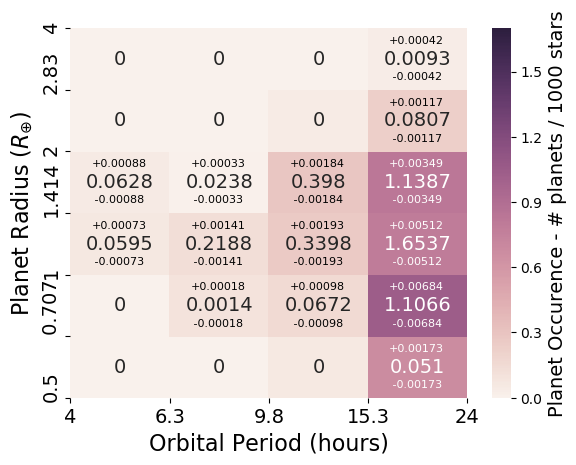

In [312]:
labels = np.array([[0,0,0,0.0093],[0,0,0,0.0807],[0.0628,0.0238,0.3980,1.1387],[0.0595,0.2188,0.3398,1.6537],[0,0.0014,0.0672,1.1066],[0,0,0,0.0510]],dtype = object)
fig, ax = plt.subplots()
ax = sns.heatmap(1000*array, annot = labels, fmt = '', annot_kws={"size": 14}, vmin=0, vmax=1.7)
plt.text(3.21,5.75,"+0.00042", size = 8)
plt.text(3.21,5.16," -0.00042", size = 8)
plt.text(3.21,4.75,"+0.00117", size = 8)
plt.text(3.21,4.16," -0.00117", size = 8)
plt.text(0.21,3.75,"+0.00088", size = 8)
plt.text(0.21,3.16," -0.00088", size = 8)
plt.text(1.21,3.75,"+0.00033", size = 8)
plt.text(1.21,3.16," -0.00033", size = 8)
plt.text(2.21,3.75,"+0.00184", size = 8)
plt.text(2.21,3.16," -0.00184", size = 8)
plt.text(3.21,3.75,"+0.00349", color = 'w', size = 8)
plt.text(3.21,3.16," -0.00349", color = 'w', size = 8)
plt.text(0.21,2.75,"+0.00073", size = 8)
plt.text(0.21,2.16," -0.00073", size = 8)
plt.text(1.21,2.75,"+0.00141", size = 8)
plt.text(1.21,2.16," -0.00141", size = 8)
plt.text(2.21,2.75,"+0.00193", size = 8)
plt.text(2.21,2.16," -0.00193", size = 8)
plt.text(3.21,2.75,"+0.00512", color = 'w', size = 8)
plt.text(3.21,2.16," -0.00512", color = 'w', size = 8)
plt.text(1.21,1.75,"+0.00018", size = 8)
plt.text(1.21,1.16," -0.00018", size = 8)
plt.text(2.21,1.75,"+0.00098", size = 8)
plt.text(2.21,1.16," -0.00098", size = 8)
plt.text(3.21,1.75,"+0.00684", color = 'w', size = 8)
plt.text(3.21,1.16," -0.00684", color = 'w', size = 8)
plt.text(3.21,0.75,"+0.00173",  color = 'w', size = 8)
plt.text(3.21,0.16," -0.00173", color = 'w',size = 8)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([4,6.3,9.8,15.3,24], fontsize = 14)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels([0.5," 0.707",1,1.414,2,2.83,4], fontsize = 14, horizontalalignment = 'right', verticalalignment = 'baseline')
cbar = ax.collections[0].colorbar
cbar.set_label('Planet Occurence - # planets / 1000 stars', fontsize = 14)
plt.xlabel("Orbital Period (hours)", fontsize = 16)
plt.ylabel("Planet Radius ($R_{\oplus}$)", fontsize = 16)

plt.show()

For Kepler-10b, the measured mass is 3.72 +/- 0.42 Earth masses. For Kepler-78b, the measured mass is 1.82 +/- 0.27 Since I use the orbital periods in the occurrence rate calculations, I'm going to identify these by its orbital period.

In [559]:
import scipy.stats
dist10 = scipy.stats.norm(3.72, 0.42)
dist78 = scipy.stats.norm(1.82, 0.27)

kep10kic = 11904151
kep10per = per[kepid.index(11904151)]
print(kepid.index(11904151))
print(len(f))
print(len(kepid))
print(kep10per)

kep78per = per[kepid.index(8435766)]
print(kep78per)

print(dist10.pdf(3.5))

53
62
62
0.8374906
0.35500753
0.828096012563806


In [24]:
for i in range(0, len(per)):
    for j in range(0, len(per)):
        if (per[i] == per[j] and i != j):
            print("yes")

len massrand 62


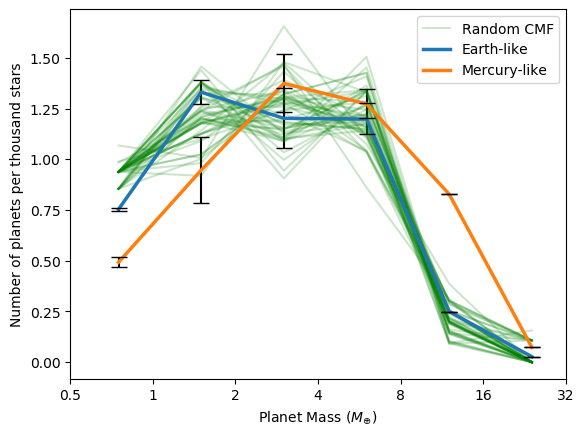

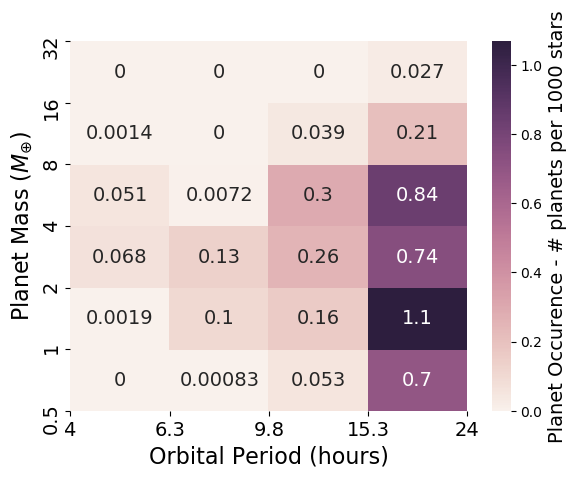

In [560]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
earthsamples = []
earthperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('EarthlikeMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             earthperiodsamples.append(float(per[kepid.index(kepid2)]))
         earthsamples = earthsamples + samplelist
         rownum += 1

mercurysamples = []
mercperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('MercuryLikeMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             mercperiodsamples.append(float(per[kepid.index(kepid2)]))
         mercurysamples = mercurysamples + samplelist
         rownum += 1

randsamples = []
massrand = []
randperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('RandomCMFMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             randperiodsamples.append(float(per[kepid.index(kepid2)]))
         massrand.append(np.percentile(list1, 50))
         randsamples = randsamples + samplelist
         rownum += 1

print("len massrand", len(massrand))

radbins = [0.5,(1/np.sqrt(2)),1,np.sqrt(2),2,2*np.sqrt(2),4]
massbins = [0.5,1,2,4,8,16,32]
perbins = [4,4*(6**0.25),4*np.sqrt(6),4*(6**0.75),24]

massarray = np.zeros((len(massbins)-1,len(perbins)-1))

massbinsflip = np.flip(massbins,0)

f = [(adivr[i]/numstars[i]) for i in range(0,len(kepid))]
f2 = [(1/numstars[i]) for i in range(0,len(kepid))]

## sum occurrence rate in bins

earthmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))
earthfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))

for i in range(len(massrand)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
                massarray[k][j] += (f[i])
                
kep10sumearth = 0
kep78sumearth = 0
earthweighted78sum = 0
earthweighted10sum = 0
eartharray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(earthperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*earthperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= earthsamples[i] >= massbinsflip[k+1]):
                eartharray[k][j] += (f[per.index(earthperiodsamples[i])])/1000
                earthmasstransitarray[k][j] += (f2[per.index(earthperiodsamples[i])])/1000
                earthfreqarray[k][j] += 1/1000
                if (earthperiodsamples[i] == kep10per):
                    kep10sumearth += (f[per.index(earthperiodsamples[i])])/1000
                    earthweighted10sum += ((f[per.index(earthperiodsamples[i])])/1000 *  dist10.pdf(earthsamples[i]))
                if (earthperiodsamples[i] == kep78per):
                    kep78sumearth += (f[per.index(earthperiodsamples[i])])/1000
                    earthweighted78sum += ((f[per.index(earthperiodsamples[i])])/1000 *  dist78.pdf(earthsamples[i]))
r = 0
                
kep10summerc = 0    
kep78summerc = 0 
mercweighted78sum = 0
mercweighted10sum = 0
mercuryarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(mercperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*mercperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= mercurysamples[i] >= massbinsflip[k+1]):
                mercuryarray[k][j] += (f[per.index(mercperiodsamples[i])])/1000
                mercmasstransitarray[k][j] += (f2[per.index(mercperiodsamples[i])])/1000
                mercfreqarray[k][j] += 1/1000
                if (mercperiodsamples[i] == kep10per):
                    kep10summerc += (f[per.index(mercperiodsamples[i])])/1000
                    mercweighted10sum += ((f[per.index(mercperiodsamples[i])])/1000 *  dist10.pdf(mercurysamples[i]))

                if (mercperiodsamples[i] == kep78per):
                    kep78summerc += (f[per.index(mercperiodsamples[i])])/1000
                    mercweighted78sum += ((f[per.index(mercperiodsamples[i])])/1000 *  dist78.pdf(mercurysamples[i]))

    
    
earthmasssum = np.zeros(len(massbins)-1)   
mercmasssum = np.zeros(len(massbins)-1) 
masssum = np.zeros(len(massbins)-1)  

merctransitsum = np.zeros(len(massbins)-1) 
earthtransitsum = np.zeros(len(massbins)-1) 

mercfreqsum = np.zeros(len(massbins)-1) 
earthfreqsum = np.zeros(len(massbins)-1) 
for j in range(len(massbins) - 1):
    for i in range(len(perbins)-1):
        masssum[j] += massarray[j][i]*1000
        earthmasssum[j] += eartharray[j][i]*1000
        mercmasssum[j] += mercuryarray[j][i]*1000
        earthtransitsum[j] += earthmasstransitarray[i][j] * 1000
        merctransitsum[j] += mercmasstransitarray[i][j] * 1000
        mercfreqsum[j] += mercfreqarray[i][j]
        earthfreqsum[j] += earthfreqarray[i][j]
        

massticks = np.zeros(len(massbins)-1) 
for i in range(len(massbins)-1):
    massticks[i] = np.log2((massbins[i+1] + massbins[i])/2)
         

       
earthwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
earthwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if earthtransitsum[i] == 0:
        earthwilsonhigh[i] = "N=0"
        earthwilsonlow[i] = "N=0"
    else:
        n = (earthfreqsum[i])/(earthtransitsum[i])
        if n == 0:
            earthwilsonhigh[i] = "n=0"
            earthwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((earthtransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((earthtransitsum[i] - (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            earthwilsonhigh[i] = ((earthmasssum[i]/earthtransitsum[i])*high) - earthmasssum[i]
            earthwilsonlow[i] = ((earthmasssum[i]/earthtransitsum[i])*low) - earthmasssum[i]

mercwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
mercwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if merctransitsum[i] == 0:
        mercwilsonhigh[i] = "N=0"
        mercwilsonlow[i] = "N=0"
    else:
        n = (mercfreqsum[i])/(merctransitsum[i])
        if n == 0:
            mercwilsonhigh[i] = "n=0"
            mercwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((merctransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((merctransitsum[i] - (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            mercwilsonhigh[i] = ((mercmasssum[i]/merctransitsum[i])*high) - mercmasssum[i]
            mercwilsonlow[i] = ((mercmasssum[i]/merctransitsum[i])*low) - mercmasssum[i]


eartherrorup = np.zeros(len(massbins)-1)
eartherrordown = np.zeros(len(massbins)-1)
mercerrorup = np.zeros(len(massbins)-1)
mercerrordown = np.zeros(len(massbins)-1)
for i in range(len(eartherrorup)):
    if earthwilsonhigh[i] == 'N=0':
        eartherrorup[i] = 0
        eartherrordown[i] = 0
        mercerrorup[i] = 0
        mercerrordown[i] = 0
    else:
        eartherrorup[i] = earthwilsonhigh[i]
        eartherrordown[i] = -1 * earthwilsonlow[i]
        mercerrorup[i] = mercwilsonhigh[i]
        mercerrordown[i] = -1 * mercwilsonlow[i]

for o in range(0,49):
    massarray = np.zeros((len(massbins)-1,len(perbins)-1))
    massrand = []
    for j in meanearthradii:
        randomcmf = np.random.normal(0.33,0.1)
        while (randomcmf <= 0):
            randomcmf = np.random.normal(0.33,0.1)
        try:
            massrand.append(getmass((getpcmb(j, randomcmf), getpmaxhat(j, randomcmf))))
        except:
            print("couldn't interpolate", randomcmf)
    for i in range(len(massrand)):
        for j in range(len(perbins)-1):
            for k in range(len(massbins)-1):
                if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
                    massarray[k][j] += (f[i])
    masssum = np.zeros(len(massbins)-1)  
    for j in range(len(massbins) - 1):
        for i in range(len(perbins)-1):
            masssum[j] += massarray[j][i]*1000
    plt.plot(massticks,np.flip(masssum,0), color = 'g', alpha = 0.2)
plt.plot(massticks,np.flip(masssum,0), color = 'g',label = 'Random CMF', alpha = 0.2)
plt.plot(massticks,np.flip(earthmasssum,0), label = 'Earth-like', linewidth = 2.5)
plt.plot(massticks,np.flip(mercmasssum,0), label = 'Mercury-like', linewidth = 2.5)

plt.errorbar(massticks,np.flip(mercmasssum,0), yerr = np.stack((mercerrorup,mercerrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.errorbar(massticks,np.flip(earthmasssum,0), yerr = np.stack((eartherrorup,eartherrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.xlabel('Planet Mass ($M_{ \oplus}$)')
plt.ylabel('Number of planets per thousand stars')
plt.xticks([-1,0,1,2,3,4,5], [0.5,1,2,4,8,16,32])
plt.legend()

array = np.zeros((len(massbins)-1,len(perbins)-1))
freqarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(randperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= randmasssamples[i] >= massbinsflip[k+1]):
                array[k][j] += (f[per.index(randperiodsamples[i])])/1000
                freqarray[k][j] += 1

import seaborn as sns


fig, ax = plt.subplots()


ax = sns.heatmap(1000*eartharray, annot = True, annot_kws={"size": 14})
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([4,6.3,9.8,15.3,24], fontsize = 14)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels([0.5,1,2,4,8,16,32], fontsize = 14)
cbar = ax.collections[0].colorbar
cbar.set_label('Planet Occurence - # planets per 1000 stars', fontsize = 14)
plt.xlabel("Orbital Period (hours)", fontsize = 16)
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 16)

plt.show()

In [26]:
print(kep10sumearth)
print(kep10summerc)
print(kep78sumearth)
print(kep78summerc)
print(earthweighted78sum)
print(earthweighted10sum)
print(mercweighted78sum)
print(mercweighted10sum)
earth10norm = kep10sumearth / earthweighted10sum
earth78norm = kep78sumearth / earthweighted78sum
merc10norm = kep10summerc / mercweighted10sum
merc78norm = kep78summerc / mercweighted78sum
print(earth10norm)
print(earth78norm)
print(merc10norm)
print(merc78norm)

4.4179183668876506e-05
4.4179183668876506e-05
3.760739763755335e-05
3.760739763755335e-05
1.1423989683638682e-05
1.4590997253920607e-06
3.390296740297408e-12
2.882171702882172e-16
30.27838529474436
3.291967051704736
153284357155.7424
11092656.636968687


I'm going to use these totals to weight the occurrence rate contributions for the planets based on a normal distribution of their measured masses. Then I'm going to renormalize the contribution to what it originally should be.

len massrand 62


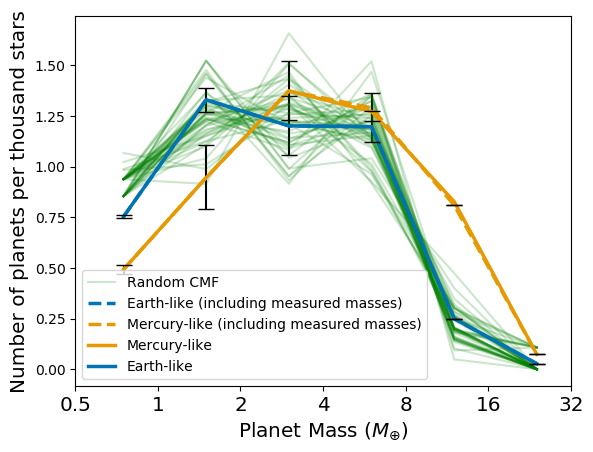

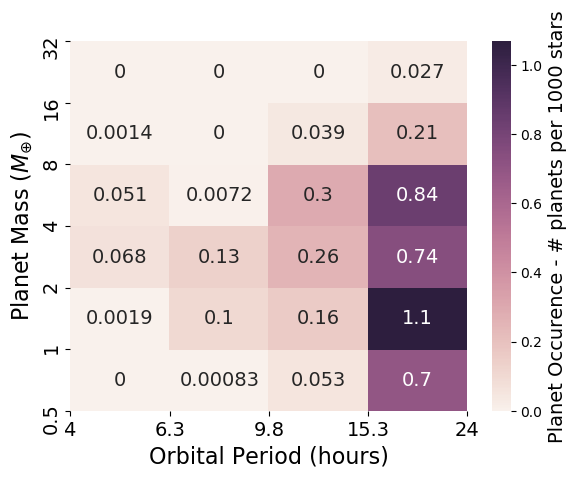

In [311]:

myblue = (0, .45, .70)


import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
earthsamples = []
earthperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('EarthlikeMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             earthperiodsamples.append(float(per[kepid.index(kepid2)]))
         earthsamples = earthsamples + samplelist
         rownum += 1

mercurysamples = []
mercperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('MercuryLikeMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             mercperiodsamples.append(float(per[kepid.index(kepid2)]))
         mercurysamples = mercurysamples + samplelist
         rownum += 1

randsamples = []
massrand = []
randperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('RandomCMFMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             randperiodsamples.append(float(per[kepid.index(kepid2)]))
         massrand.append(np.percentile(list1, 50))
         randsamples = randsamples + samplelist
         rownum += 1

print("len massrand", len(massrand))

radbins = [0.5,(1/np.sqrt(2)),1,np.sqrt(2),2,2*np.sqrt(2),4]
massbins = [0.5,1,2,4,8,16,32]
perbins = [4,4*(6**0.25),4*np.sqrt(6),4*(6**0.75),24]

massarray = np.zeros((len(massbins)-1,len(perbins)-1))

massbinsflip = np.flip(massbins,0)

f = [(adivr[i]/numstars[i]) for i in range(0,len(kepid))]
f2 = [(1/numstars[i]) for i in range(0,len(kepid))]

## sum occurrence rate in bins

earthmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))
earthfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))

for i in range(len(massrand)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
                massarray[k][j] += (f[i])
                
eartharray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(earthperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*earthperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= earthsamples[i] >= massbinsflip[k+1]):
                earthmasstransitarray[k][j] += (f2[per.index(earthperiodsamples[i])])/1000
                earthfreqarray[k][j] += 1/1000
                if (earthperiodsamples[i] == kep10per):
                    eartharray[k][j] += ((f[per.index(earthperiodsamples[i])])/1000) * dist10.pdf(earthsamples[i]) * earth10norm
                elif (earthperiodsamples[i] == kep78per):
                    eartharray[k][j] += ((f[per.index(earthperiodsamples[i])])/1000) * dist78.pdf(earthsamples[i]) * earth78norm
                else:
                    eartharray[k][j] += (f[per.index(earthperiodsamples[i])])/1000
                          
mercuryarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(mercperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*mercperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= mercurysamples[i] >= massbinsflip[k+1]):
                mercmasstransitarray[k][j] += (f2[per.index(mercperiodsamples[i])])/1000
                mercfreqarray[k][j] += 1/1000
                if (mercperiodsamples[i] == kep10per):
                    mercuryarray[k][j] += (f[per.index(mercperiodsamples[i])])/1000 * dist10.pdf(mercurysamples[i]) * merc10norm
                elif (mercperiodsamples[i] == kep78per):
                    mercuryarray[k][j] += (f[per.index(mercperiodsamples[i])])/1000 * dist78.pdf(mercurysamples[i]) * merc78norm
                else:
                    mercuryarray[k][j] += (f[per.index(mercperiodsamples[i])])/1000

    
    
earthmasssum2 = np.zeros(len(massbins)-1)   
mercmasssum2 = np.zeros(len(massbins)-1) 
masssum = np.zeros(len(massbins)-1)  

merctransitsum = np.zeros(len(massbins)-1) 
earthtransitsum = np.zeros(len(massbins)-1) 

mercfreqsum = np.zeros(len(massbins)-1) 
earthfreqsum = np.zeros(len(massbins)-1) 
for j in range(len(massbins) - 1):
    for i in range(len(perbins)-1):
        masssum[j] += massarray[j][i]*1000
        earthmasssum2[j] += eartharray[j][i]*1000
        mercmasssum2[j] += mercuryarray[j][i]*1000
        earthtransitsum[j] += earthmasstransitarray[i][j] * 1000
        merctransitsum[j] += mercmasstransitarray[i][j] * 1000
        mercfreqsum[j] += mercfreqarray[i][j]
        earthfreqsum[j] += earthfreqarray[i][j]
        

massticks = np.zeros(len(massbins)-1) 
for i in range(len(massbins)-1):
    massticks[i] = np.log2((massbins[i+1] + massbins[i])/2)
         

       
earthwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
earthwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if earthtransitsum[i] == 0:
        earthwilsonhigh[i] = "N=0"
        earthwilsonlow[i] = "N=0"
    else:
        n = (earthfreqsum[i])/(earthtransitsum[i])
        if n == 0:
            earthwilsonhigh[i] = "n=0"
            earthwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((earthtransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((earthtransitsum[i] - (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            earthwilsonhigh[i] = ((earthmasssum2[i]/earthtransitsum[i])*high) - earthmasssum2[i]
            earthwilsonlow[i] = ((earthmasssum2[i]/earthtransitsum[i])*low) - earthmasssum2[i]

mercwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
mercwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if merctransitsum[i] == 0:
        mercwilsonhigh[i] = "N=0"
        mercwilsonlow[i] = "N=0"
    else:
        n = (mercfreqsum[i])/(merctransitsum[i])
        if n == 0:
            mercwilsonhigh[i] = "n=0"
            mercwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((merctransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((merctransitsum[i] - (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            mercwilsonhigh[i] = ((mercmasssum2[i]/merctransitsum[i])*high) - mercmasssum2[i]
            mercwilsonlow[i] = ((mercmasssum2[i]/merctransitsum[i])*low) - mercmasssum2[i]


eartherrorup = np.zeros(len(massbins)-1)
eartherrordown = np.zeros(len(massbins)-1)
mercerrorup = np.zeros(len(massbins)-1)
mercerrordown = np.zeros(len(massbins)-1)
for i in range(len(eartherrorup)):
    if earthwilsonhigh[i] == 'N=0':
        eartherrorup[i] = 0
        eartherrordown[i] = 0
        mercerrorup[i] = 0
        mercerrordown[i] = 0
    else:
        eartherrorup[i] = earthwilsonhigh[i]
        eartherrordown[i] = -1 * earthwilsonlow[i]
        mercerrorup[i] = mercwilsonhigh[i]
        mercerrordown[i] = -1 * mercwilsonlow[i]

q = plt.figure()        
mygold = (.9, .6, 0)
for o in range(0,49):
    massarray = np.zeros((len(massbins)-1,len(perbins)-1))
    massrand = []
    for j in meanearthradii:
        randomcmf = np.random.normal(0.33,0.1)
        while (randomcmf <= 0):
            randomcmf = np.random.normal(0.33,0.1)
        try:
            massrand.append(getmass((getpcmb(j, randomcmf), getpmaxhat(j, randomcmf))))
        except:
            print("couldn't interpolate", randomcmf)
    for i in range(len(massrand)):
        for j in range(len(perbins)-1):
            for k in range(len(massbins)-1):
                if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
                    massarray[k][j] += (f[i])
    masssum = np.zeros(len(massbins)-1)  
    for j in range(len(massbins) - 1):
        for i in range(len(perbins)-1):
            masssum[j] += massarray[j][i]*1000
    plt.plot(massticks,np.flip(masssum,0), color = 'g', alpha = 0.2)
plt.plot(massticks,np.flip(masssum,0), color = 'g',label = 'Random CMF', alpha = 0.2)
plt.plot(massticks,np.flip(earthmasssum2,0), label = 'Earth-like (including measured masses)', color = myblue, linestyle='dashed', linewidth = 2.5)
plt.plot(massticks,np.flip(mercmasssum2,0), label = 'Mercury-like (including measured masses)', color = mygold, linestyle='dashed', linewidth = 2.5)
plt.plot(massticks,np.flip(mercmasssum,0), label = 'Mercury-like', color = mygold, linewidth = 2.5)
plt.plot(massticks,np.flip(earthmasssum,0), label = 'Earth-like', color = myblue, linewidth = 2.5)



plt.errorbar(massticks,np.flip(mercmasssum2,0), yerr = np.stack((mercerrorup,mercerrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.errorbar(massticks,np.flip(earthmasssum2,0), yerr = np.stack((eartherrorup,eartherrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.xlabel('Planet Mass ($M_{ \oplus}$)', fontsize = 'x-large')
plt.ylabel('Number of planets per thousand stars', fontsize = 'x-large')
plt.xticks([-1,0,1,2,3,4,5], [0.5,1,2,4,8,16,32], fontsize = 'x-large')
plt.legend()
q.savefig("PosterFig5.pdf", bbox_inches = "tight")

array = np.zeros((len(massbins)-1,len(perbins)-1))
freqarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(randperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= randmasssamples[i] >= massbinsflip[k+1]):
                array[k][j] += (f[per.index(randperiodsamples[i])])/1000
                freqarray[k][j] += 1

import seaborn as sns


fig, ax = plt.subplots()


ax = sns.heatmap(1000*eartharray, annot = True, annot_kws={"size": 14})
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([4,6.3,9.8,15.3,24], fontsize = 14)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels([0.5,1,2,4,8,16,32], fontsize = 14)
cbar = ax.collections[0].colorbar
cbar.set_label('Planet Occurence - # planets per 1000 stars', fontsize = 14)
plt.xlabel("Orbital Period (hours)", fontsize = 16)
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 16)

plt.show();

In [562]:
mercmasssum2

array([0.07349714, 0.80968095, 1.29054287, 1.373663  , 0.9460433 ,
       0.49251543])

In [550]:
len(mercurysamples)

61904

In [28]:
mercerrorup

array([0.02354042, 0.15571578, 0.14190692, 0.06727596, 0.        ,
       0.        ])

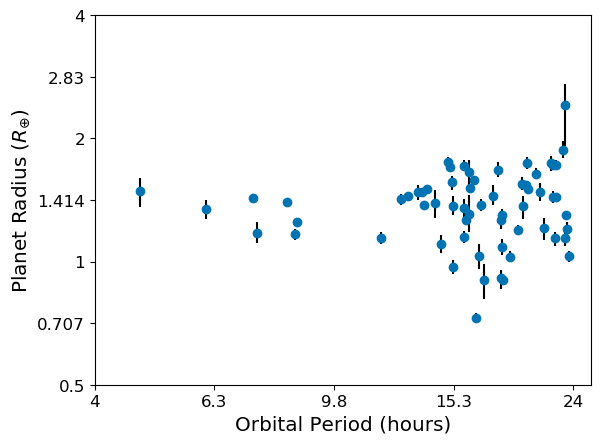

In [307]:
per2 = [24 * i for i in per]
down = [mean - value for mean, value in zip(meanearthradii, radiierrdown)]
up = [value - mean for mean, value in zip(meanearthradii, radiierrup)]

g = plt.figure()
plt.loglog(per2,meanearthradii, 'o', basex = (6**0.25), basey = np.sqrt(2), color = myblue)
plt.errorbar(per2,meanearthradii, yerr = [down, up], linestyle = 'None', ecolor = 'k')
plt.yticks(radbins, [0.5,0.707,1,1.414,2,2.83,4], fontsize = 'large')
plt.xticks(perbins,[4,6.3,9.8,15.3,24], fontsize = 'large')
plt.xlabel("Orbital Period (hours)", fontsize = 'x-large')
plt.ylabel("Planet Radius ($R_{ \oplus}$)", fontsize = 'x-large')
##plt.title("Planet Radius vs. Orbital Period")
g.savefig("PosterFig2.pdf", bbox_inches = "tight")
plt.show()

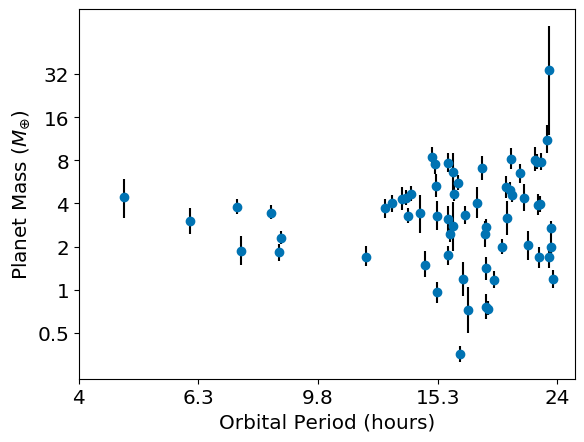

In [308]:
down = [mean - value for mean, value in zip(meanrandmasses, randerrdown)]
up = [value - mean for mean, value in zip(meanrandmasses, randerrup)]

h = plt.figure()
plt.loglog(per2,meanrandmasses, 'o', basex = (6**0.25), basey = np.sqrt(2), color = myblue)
plt.errorbar(per2,meanrandmasses, yerr = [down, up], linestyle = 'None', ecolor = 'k')
plt.yticks(massbins, [0.5,1,2,4,8,16,32], fontsize = 'x-large')
plt.xticks(perbins,[4,6.3,9.8,15.3,24], fontsize = 'x-large')
plt.xlabel("Orbital Period (hours)", fontsize = 'x-large')
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 'x-large')
h.savefig("PosterFig4.pdf", bbox_inches = "tight")
plt.show()

In [31]:
np.where(randerr == np.max(randerr))

(array([33]),)

In [32]:
mercerr[33]

nan

In [33]:
meanmercmasses[33]

nan

In [34]:
meanearthradii[33]

2.4109850247728475

In [35]:
radiierrup[33]

1.9111426228077115

In [36]:
meanrandmasses[33]

33.92893115184489

In [37]:
randerr[33]

45.950025056775516

In [38]:
meanearthmasses[33]

34.60479146806121

In [39]:
eartherr[33]

32.68412625429588

In [40]:
koi[33]

3106

In [41]:
np.max(meanearthradii)

2.4109850247728475

In [42]:
print(5)

5


## Grid attempts (not good)

So here are all of the masses that I was able to interpolate using Ellen's grids.

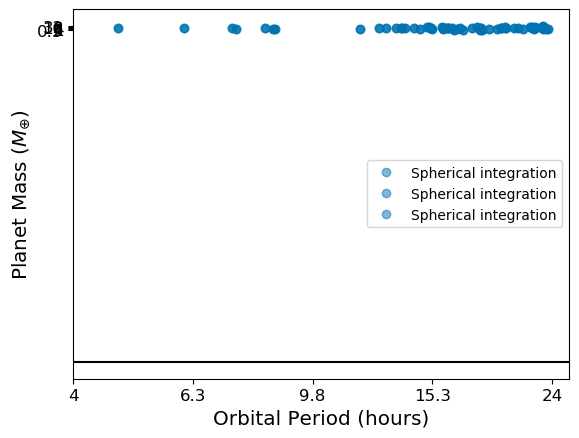

In [45]:
plt.loglog(per2,meanearthmasses, 'o', basex = (6**0.25), basey = np.sqrt(2), color = myblue, alpha = 0.5, label = "Spherical integration")
#plt.loglog(per2,medians, 'o', basex = (6**0.25), basey = np.sqrt(2), color = 'r', alpha = 0.5, label = "George interpolation")
#plt.errorbar(per2,medians, yerr = [[i - j for i, j in zip(medians,ellen_errdown)], [j - i for i, j in zip(medians, ellen_errup)]], linestyle = 'None', ecolor = 'k')
plt.yticks(massbins, [0.5,1,2,4,8,16,32], fontsize = 'large')
plt.axhline(y=0, color='k', linestyle='-')
plt.xticks(perbins,[4,6.3,9.8,15.3,24], fontsize = 'large')
plt.xlabel("Orbital Period (hours)", fontsize = 'x-large')
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 'x-large')
plt.legend()
plt.show()

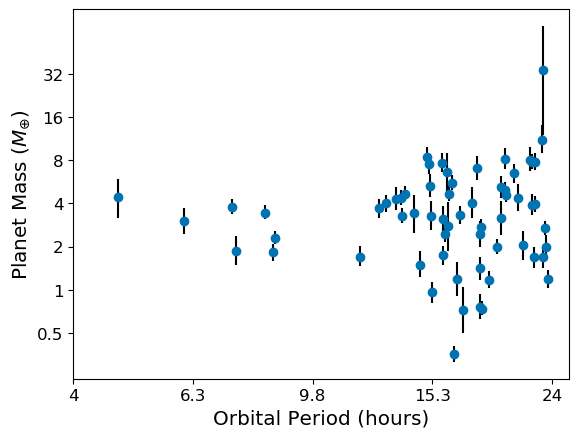

In [46]:
plt.loglog(per2,meanrandmasses, 'o', basex = (6**0.25), basey = np.sqrt(2), color = myblue)
plt.errorbar(per2,meanrandmasses, yerr = [down, up], linestyle = 'None', ecolor = 'k')
plt.yticks(massbins, [0.5,1,2,4,8,16,32], fontsize = 'large')
plt.xticks(perbins,[4,6.3,9.8,15.3,24], fontsize = 'large')
plt.xlabel("Orbital Period (hours)", fontsize = 'x-large')
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 'x-large')
plt.show()

## Machine learning masses

In [260]:
def parse_samples(samples):
    ## assume 1000 samples for each planet
    num_planets = len(samples)//1000
    print(num_planets)
    medians = []
    uperr = []
    downerr = []
    for i in range(0, num_planets):
        medians.append(np.median(samples[1000*i:1000*(i+1)]))
        uperr.append(np.percentile(samples[1000*i:1000*(i+1)], 84.15) - np.median(samples[1000*i:1000*(i+1)]))
        downerr.append(np.median(samples[1000*i:1000*(i+1)]) - np.percentile(samples[1000*i:1000*(i+1)],15.85))
    return np.array(medians), np.array(uperr), np.array(downerr)

In [261]:
def get_residuals(array):
    ## gets residuals relative to earth-like masses
    return np.array([spher-calc for spher,calc in zip(meanearthmasses, array)])

def get_relative_residuals(array):
    ## gets relative residuals relative to earth-like masses
    return np.array([((spher-calc)/spher) for spher,calc in zip(meanearthmasses, array)])

Comparing spherical masses

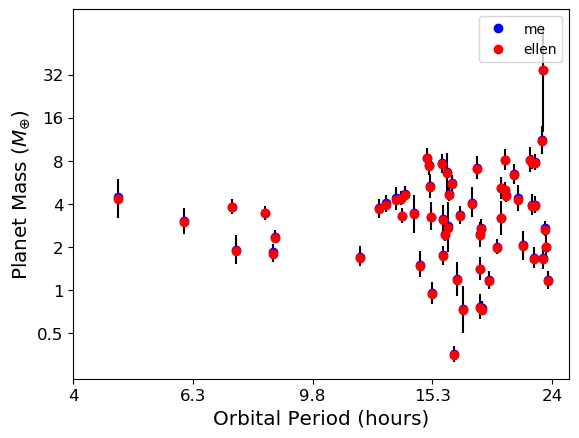

In [262]:
ellen_spherical_masses = np.loadtxt("ellen_spherical.txt")
plt.loglog(per2,meanearthmasses, 'bo', basex = (6**0.25), basey = np.sqrt(2), label = "me")
plt.loglog(per2,ellen_spherical_masses, 'ro', basex = (6**0.25), basey = np.sqrt(2), label = "ellen")
plt.errorbar(per2,meanearthmasses, yerr = [down, up], linestyle = 'None', ecolor = 'k')
plt.yticks(massbins, [0.5,1,2,4,8,16,32], fontsize = 'large')
plt.xticks(perbins,[4,6.3,9.8,15.3,24], fontsize = 'large')
plt.xlabel("Orbital Period (hours)", fontsize = 'x-large')
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 'x-large')
plt.legend()
plt.show()

Here I'm going to compare linearly interpolated values (not machine learning).

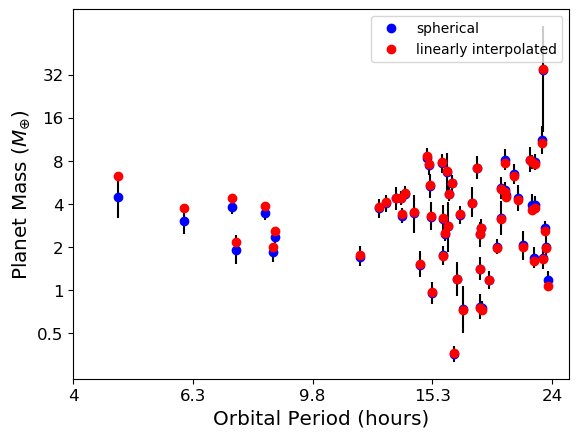

In [263]:
linear_masses = np.loadtxt("linearearth.txt")
plt.loglog(per2,meanearthmasses, 'bo', basex = (6**0.25), basey = np.sqrt(2), label = "spherical")
plt.loglog(per2,linear_masses, 'ro', basex = (6**0.25), basey = np.sqrt(2), label = "linearly interpolated")
plt.errorbar(per2,meanearthmasses, yerr = [down, up], linestyle = 'None', ecolor = 'k')
plt.yticks(massbins, [0.5,1,2,4,8,16,32], fontsize = 'large')
plt.xticks(perbins,[4,6.3,9.8,15.3,24], fontsize = 'large')
plt.xlabel("Orbital Period (hours)", fontsize = 'x-large')
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 'x-large')
plt.legend()
plt.show()

In [264]:
ml_masses, up_err,down_err = np.loadtxt("earth_masses.txt", unpack = True)
print(len(ml_masses))

62


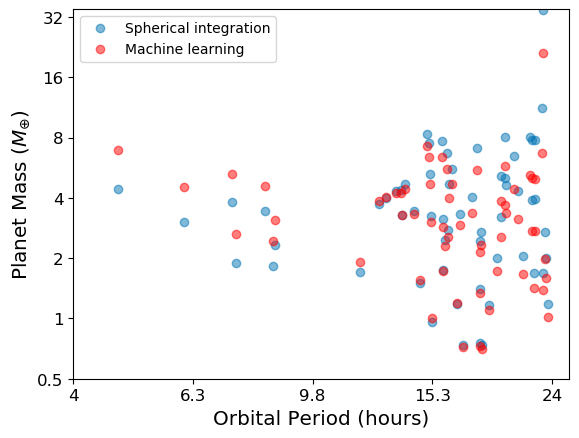

In [265]:
plt.loglog(per2,meanearthmasses, 'o', basex = (6**0.25), basey = np.sqrt(2), color = myblue, alpha = 0.5, label = "Spherical integration")
plt.loglog(per2,ml_masses, 'o', basex = (6**0.25), basey = np.sqrt(2), color = 'r', alpha = 0.5, label = "Machine learning")
#plt.errorbar(per2,ml_masses, yerr = [down_err, up_err], linestyle = 'None', ecolor = 'k')
plt.axhline(y=0, color='k', linestyle='-')
plt.yticks(massbins, [0.5,1,2,4,8,16,32], fontsize = 'large')
plt.xticks(perbins,[4,6.3,9.8,15.3,24], fontsize = 'large')
plt.xlabel("Orbital Period (hours)", fontsize = 'x-large')
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 'x-large')
plt.ylim(0.5,35)
plt.legend()
plt.show()

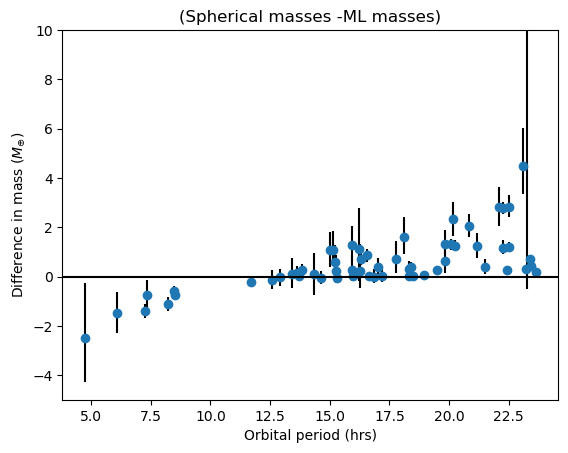

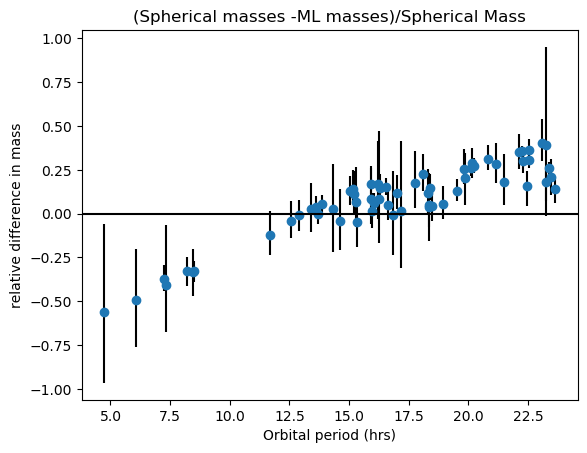

In [266]:
residuals = [i-j for i,j in zip(meanearthmasses, ml_masses)]
rel_residuals = [(i-j)/i for i,j in zip(meanearthmasses, ml_masses)]

plt.plot(per2, residuals, 'o')
plt.errorbar(per2,residuals, yerr = [down_err, up_err], linestyle = 'None', ecolor = 'k')
plt.axhline(y=0, color='k', linestyle='-')
plt.xlabel("Orbital period (hrs)")
plt.ylabel("Difference in mass ($M_{\oplus}$)")
plt.title("(Spherical masses -ML masses)")
plt.ylim(-5, 10)
plt.show()

plt.plot(per2, rel_residuals, 'o')
plt.errorbar(per2,rel_residuals, yerr = [down_err/meanearthmasses, up_err/meanearthmasses], linestyle = 'None', ecolor = 'k')
plt.axhline(y=0, color='k', linestyle='-')
plt.xlabel("Orbital period (hrs)")
plt.ylabel("relative difference in mass")
plt.title("(Spherical masses -ML masses)/Spherical Mass")
plt.show()

The above plots don't have the correct error bars. I've regenerated 1000 spherical samples and 1000 machine learning samples for each planet. I'm going to calculate errors based on their differences and graph those.

In [267]:
ml_samples = np.loadtxt("earth_mass_samples.txt")
print(len(ml_samples))
sph_samples = np.loadtxt("ellen_spherical_samples.txt")
print(len(sph_samples))


62000
62000


In [268]:
def get_residual_distribution(samples):
    return parse_samples([spher-calc for spher,calc in zip(sph_samples, samples)])
    

In [295]:
res = sph_samples - ml_samples
median_residuals = []
res_uperr = []
res_downerr = []
med_ml = []
med_sph = []

sph_uperr = []
sph_downerr = []

for i in range(62):
    planet_list = res[(1000*i) : (1000*(i+1))]
    planet_list_ml = ml_samples[(1000*i) : (1000*(i+1))]
    planet_list_sph = sph_samples[(1000*i) : (1000*(i+1))]
    med_ml.append(np.median(planet_list_ml))
    med_sph.append(np.median(planet_list_sph))
    median_residuals.append(np.median(planet_list))
    res_uperr.append(np.percentile(planet_list, 84.15) - np.median(planet_list))
    res_downerr.append(np.median(planet_list) - np.percentile(planet_list,15.85))
    sph_uperr.append(np.percentile(planet_list_sph, 84.15) - np.median(planet_list_sph))
    sph_downerr.append(np.median(planet_list_sph) - np.percentile(planet_list_sph,15.85))

print(len(median_residuals), len(res_uperr), len(res_downerr))

62 62 62


In [270]:
median_residuals, res_uperr, res_downerr = get_residual_distribution(ml_samples)

62


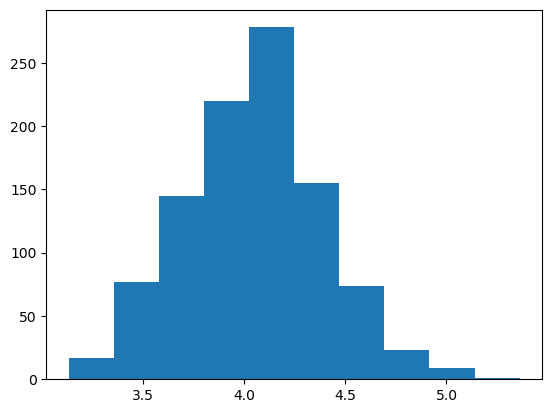

In [271]:
plt.hist(planet_list_ml)
plt.show()

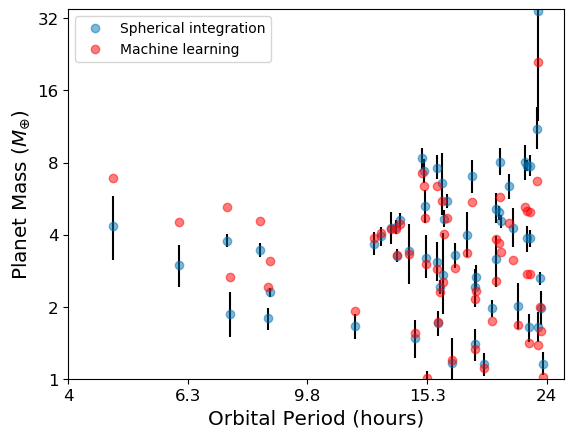

In [272]:
plt.loglog(per2,med_sph, 'o', basex = (6**0.25), basey = np.sqrt(2), color = myblue, alpha = 0.5, label = "Spherical integration")
plt.loglog(per2,med_ml, 'o', basex = (6**0.25), basey = np.sqrt(2), color = 'r', alpha = 0.5, label = "Machine learning")
plt.errorbar(per2,med_sph, yerr = [sph_downerr, sph_uperr], linestyle = 'None', ecolor = 'k')
plt.yticks(massbins, [0.5,1,2,4,8,16,32], fontsize = 'large')
plt.axhline(y=0, color='k', linestyle='-')
plt.xticks(perbins,[4,6.3,9.8,15.3,24], fontsize = 'large')
plt.xlabel("Orbital Period (hours)", fontsize = 'x-large')
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 'x-large')
plt.ylim(1,35)
plt.legend()
plt.show()

In [273]:
print(len(median_residuals))

62


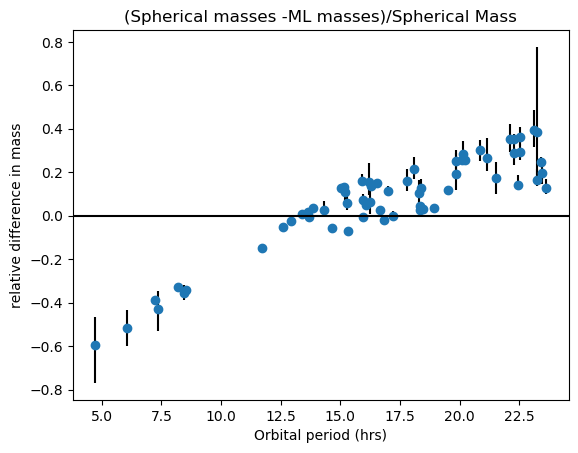

In [274]:
plt.plot(per2, median_residuals/np.array(med_sph), 'o')
plt.errorbar(per2,median_residuals/np.array(med_sph), yerr = [res_downerr/np.array(med_sph), res_uperr/np.array(med_sph)], linestyle = 'None', ecolor = 'k')
plt.axhline(y=0, color='k', linestyle='-')
plt.xlabel("Orbital period (hrs)")
plt.ylabel("relative difference in mass")
plt.title("(Spherical masses -ML masses)/Spherical Mass")
plt.show()

In [275]:
li_samples = np.loadtxt("linear_interp_samples.txt")
med_li, li_uperr, li_downerr = parse_samples(li_samples)
#li_samples = 10**li_samples
# med_li = []
# for i in range(62):
#     planet_list_li = li_samples[(1000*i) : (1000*(i+1)) - 1]
#     med_li.append(np.median(planet_list_li))

nn_samples = np.loadtxt("nn_interp_samples.txt")
med_nn, nn_uperr, nn_downerr = parse_samples(nn_samples)
#li_samples = 10**li_samples
# med_nn = []
# for i in range(62):
#     planet_list_nn = nn_samples[(1000*i) : (1000*(i+1)) - 1]
#     med_nn.append(np.median(planet_list_nn))

62


/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


62


In [276]:
med_li


array([ 6.60442919,  1.96806655,  2.760402  ,  2.69400587,  4.09001417,
        4.42364783,  3.53342031,  2.35885923,  4.8195304 ,  2.23118648,
        4.9359855 ,  3.6513942 ,  2.20815892,  2.21467186,  7.40522029,
        7.84457967,  5.16696079,  9.25168827,  3.64896848,  4.77901342,
        2.22730383,  6.87528586,  9.42067086,  3.10244592,  5.84898498,
        4.86924426,  1.92461666,  0.80230323,  0.81638333,  5.82117628,
        1.67426865,  2.83805572,  1.00106901,         nan,  1.90221842,
       16.29919754,  2.19702115,  0.79730232,  1.26465884,  4.89102339,
        0.36480281,  3.63530467,  5.14836711,  8.08828671,  5.95613557,
        3.36238979,  2.5712241 ,  7.83710062,  8.81949263,  4.62937657,
        2.62714011,  1.57250734, 10.31746655,  6.36970267,  3.86803394,
        1.57048376,  4.19385646,  1.22830161,  4.23914864, 10.19509473,
        5.9625681 ,  4.5338278 ])

In [277]:
linear_medians = np.loadtxt("linear_medians.txt")
linear_medians

array([ 6.60442919,  1.96806655,  2.760402  ,  2.69400587,  4.09001417,
        4.42364783,  3.53342031,  2.35885923,  4.8195304 ,  2.23118648,
        4.9359855 ,  3.6513942 ,  2.20815892,  2.21467186,  7.40522029,
        7.84457967,  5.16696079,  9.25168827,  3.64896848,  4.77901342,
        2.22730383,  6.87528586,  9.42067086,  3.10244592,  5.84898498,
        4.86924426,  1.92461666,  0.80230323,  0.81638328,  5.82117628,
        1.67426865,  2.83805572,  1.00106901, 35.80650595,  1.90221842,
       16.29919754,  2.19702115,  0.79730232,  1.26465884,  4.89102339,
        0.36480281,  3.63530467,  5.14836711,  8.08828671,  5.95613557,
        3.36238979,  2.5712241 ,  7.83710062,  8.81949263,  4.62937657,
        2.62714011,  1.57250734, 10.31746655,  6.36970267,  3.86803394,
        1.57048376,  4.19385646,  1.22830161,  4.23914864, 10.19509473,
        5.9625681 ,  4.5338278 ])

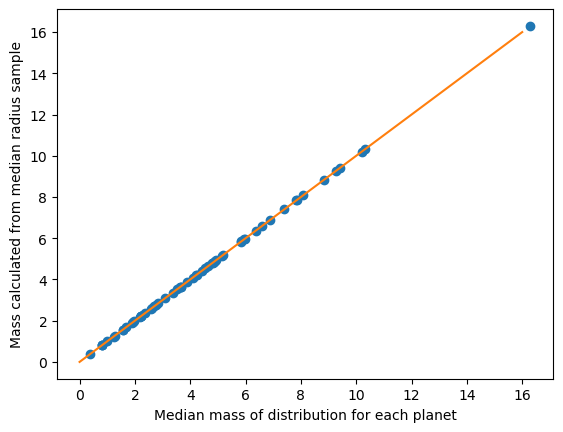

In [278]:
plt.plot(med_li, linear_medians, 'o')
plt.plot(np.linspace(0,16), np.linspace(0,16))
plt.xlabel("Median mass of distribution for each planet")
plt.ylabel("Mass calculated from median radius sample")
plt.show()

Okay, this is good. This was just a sanity check that the linear interpolation for the median radii and the median of the interpolated masses for the radii samples are the same. I'm not sure what happened in the graph that's a bit above this one, but I'm going to use these.

62


/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


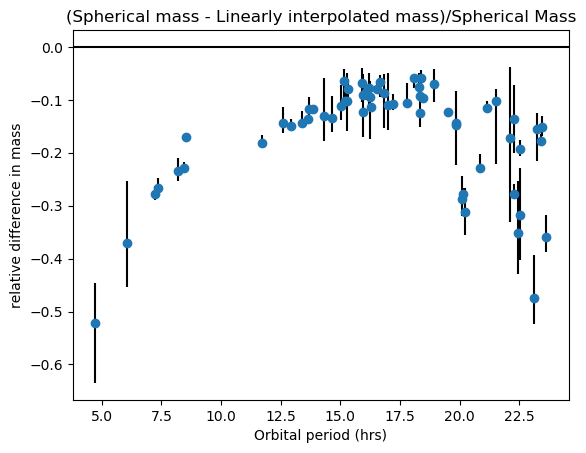

In [279]:
li_res, li_res_uperr, li_res_downerr = get_residual_distribution(li_samples)
plt.plot(per2, li_res/np.array(med_sph), 'o')
plt.errorbar(per2,li_res/np.array(med_sph), yerr = [li_res_downerr/np.array(med_sph), li_res_uperr/np.array(med_sph)], linestyle = 'None', ecolor = 'k')
## ^^ to get relative residuals
plt.axhline(y=0, color='k', linestyle='-')
plt.xlabel("Orbital period (hrs)")
plt.ylabel("relative difference in mass")
plt.title("(Spherical mass - Linearly interpolated mass)/Spherical Mass")
plt.show()

In [394]:
squishv2_samples = np.loadtxt("squishv2masssamples5.txt")
med_v2, v2_uperr, v2_downerr = parse_samples(v2_samples)
v2_res, v2_res_uperr, v2_res_downerr = get_residual_distribution(squishv2_samples)
plt.plot(per2, v2_res/np.array(med_sph), 'o')
plt.errorbar(per2,v2_res/np.array(med_sph), yerr = [v2_res_downerr/np.array(med_sph), v2_res_uperr/np.array(med_sph)], linestyle = 'None', ecolor = 'k')
## ^^ to get relative residuals
plt.axhline(y=0, color='k', linestyle='-')
plt.xlabel("Orbital period (hrs)")
plt.ylabel("relative difference in mass")
plt.title("(Spherical mass - squishv2 mass)/Spherical Mass")
plt.show()

62
0


ValueError: operands could not be broadcast together with shapes (0,) (62,) 

In [387]:
print(np.where((v2_res/np.array(med_sph))<-5))
print(per[40])
print(meanearthradii[40])

print(med_sph[40])
print(med_v2[40])

(array([40]),)
0.69384332
0.7288173208418447
0.3477411460033524
2.0435190200805664


In [388]:
print(med_sph - med_v2)

[-5.58202361 -2.22949667 -0.22782647 -2.79411144 -4.17094094  0.55019688
 -0.61542097 -3.27688231 -3.07293785 -0.3329557   1.11064576 -0.83468927
 -0.64896377 -0.43788069  2.7930502   2.80464647  0.67932704  2.74228478
 -0.15466636  1.34312488 -0.63894878  1.95383634  4.32550027  0.20383905
  1.70092555 -0.17164118 -1.43141702 -1.58015803 -1.48366115  0.70077856
 -1.74379402 -0.53933388 -1.73676774 28.07729679 -0.57166717  7.03317723
 -2.96495407 -1.47305249 -1.53404559 -0.24621639 -1.69577787  0.25115901
  0.14290022  2.55086751  1.41766737 -0.48203984 -0.43810423  2.29126287
  4.21892496  1.15419862 -0.79154301 -0.90486645  4.14757892  1.56892036
 -0.62711605 -1.18445294 -0.89063525 -1.28826767 -2.63503264  4.26548849
  1.28352668 -0.58988713]


In [389]:
rr = (sph_samples - squishv2_samples)/sph_samples
print(rr)

[-0.66322845 -1.31956305 -0.67416758 ... -0.23872278 -0.16519774
 -0.27959339]


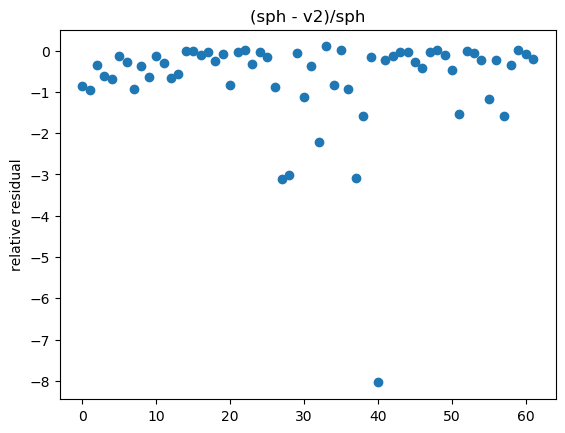

(array([10768, 15001, 15004, ..., 59997, 59998, 59999]),)


In [390]:
ff = []
for i in range(len(rr)//1000):
    ff.append(np.median(rr[1000*i:1000*(i+1)]))
plt.plot(ff, 'o')
plt.ylabel("relative residual")
plt.title("(sph - v2)/sph")
plt.show()
print(np.where(rr > 0))

34.3527761088082
0.96896529
2.4109850247728475


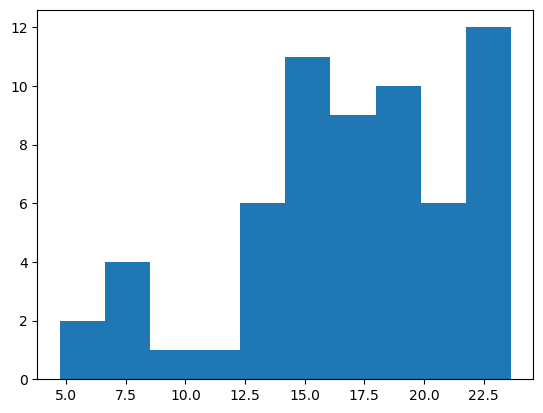

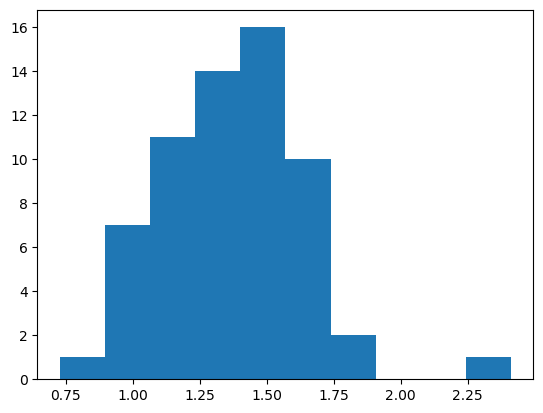

In [391]:
print(med_sph[33])
print(per[33])
print(meanearthradii[33])
## check that parameter space of squishv2 sufficiently covers these parameters
plt.hist(per2)
plt.show()
plt.figure()
plt.hist(meanearthradii)
plt.show()

[9.92521739 3.89406282 2.88623869 5.09477699 7.15711999 3.43771833
 3.81864727 5.13303006 6.84550393 2.30806267 2.75174117 4.10123944
 2.61615086 2.45884508 4.21324289 3.57353729 3.95487988 5.58089113
 3.44147962 2.92151308 2.28655022 4.61187947 3.70690084 2.43145835
 3.41009039 4.46073186 3.14157325 2.30179566 2.22959387 4.5666045
 3.2189576  3.25918931 2.67229801 6.27547932 2.21875167 4.01458406
 4.75285995 2.2006166  2.69810188 4.51297665 2.04351902 2.91202843
 4.46592999 5.03533101 4.11689532 3.56894636 2.84562761 5.10133767
 3.54032594 2.72415781 3.21116579 2.06236923 3.89735943 3.38091236
 4.03969634 2.57956153 4.5585475  2.43680269 6.07058358 3.4741537
 3.26154023 4.53354728]
[8.083392071723939, 3.2581093311309814, 3.60442191362381, 3.7302211940288545, 5.017907726764679, 4.5323363780975345, 4.06107075214386, 3.5956817746162413, 5.210538232326508, 3.230695593357086, 4.365702605247497, 4.216712629795074, 3.262736284732819, 3.1500788629055023, 7.13268210887909, 6.372563982009888, 5

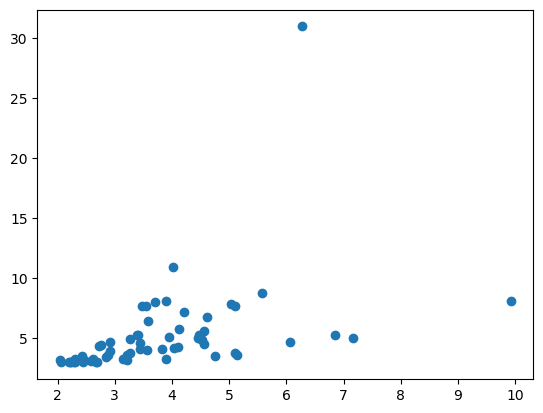

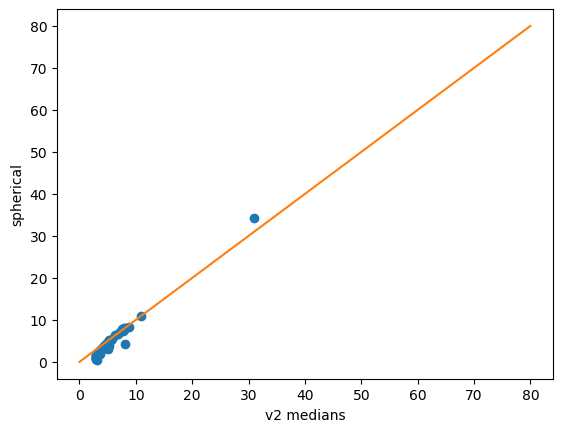

In [392]:
print(med_v2)
mm = []
upp = []
low = []
for i in range(len(squishv2_samples)//1000):
    mm.append(np.median(squishv2_samples[1000*i:1000*(i+1)]))
    upp.append(np.percentile(squishv2_samples[1000*i:1000*(i+1)], 84.15))
    low.append(np.percentile(squishv2_samples[1000*i:1000*(i+1)], 15.85))
print(mm)

plt.plot(med_v2, mm, 'o')
plt.show()
plt.plot(mm, med_sph, 'o')
plt.plot(np.linspace(0,80), np.linspace(0,80))
plt.xlabel("v2 medians")
plt.ylabel("spherical")
plt.show()


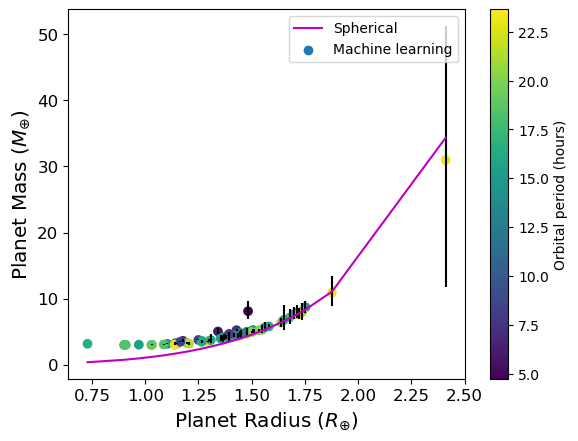

In [393]:
e = plt.figure()
plt.scatter(meanearthradii, mm, c = per2, label = "Machine learning",)
plt.plot(np.sort(meanearthradii), [x for y, x in sorted(zip(meanearthradii, med_sph))], label = "Spherical", c = 'm')
#plt.plot(meanearthradii, med_sph, label = "Spherical")
plt.errorbar(meanearthradii,mm,[[i-j for i,j in zip(mm, low)],[i-j for i,j in zip(upp, mm)]],ecolor = 'k',ls = 'None')
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 'x-large')
plt.xlabel("Planet Radius ($R_{ \oplus}$)", fontsize = 'x-large')
cbar = plt.colorbar()
cbar.set_label("Orbital period (hours)")
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.legend()
e.savefig("PosterFig7.pdf", bbox_inches = "tight")
plt.show()

In [117]:
linspacerad = np.linspace(0, 2.25)
ten_hr_masses = np.loadtxt("ten_hr_linspace.txt")
ten_hr_masses = 10**ten_hr_masses
sixteen_hr_masses = np.loadtxt("16_hr_linspace.txt")
sixteen_hr_masses = 10**sixteen_hr_masses
four_hr_masses = np.loadtxt("4_hr_linspace.txt")
four_hr_masses = 10**four_hr_masses
t4_hr_masses = np.loadtxt("24_hr_linspace.txt")
t4_hr_masses = 10**t4_hr_masses

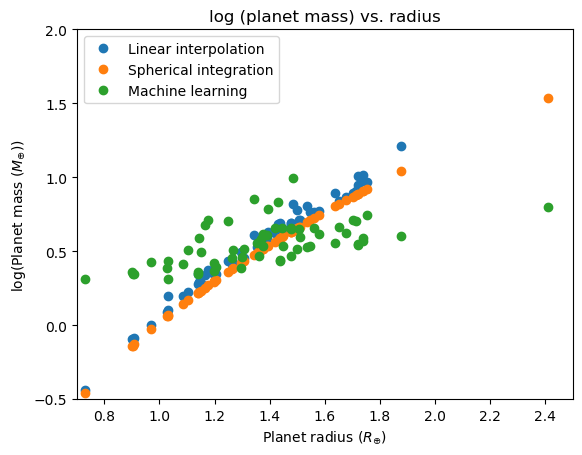

In [294]:
f = plt.figure()
plt.plot(meanearthradii, np.log10(med_li), 'o', label = "Linear interpolation")
#plt.plot(meanearthradii, np.log10(med_nn), 'o', label = "NN")
plt.plot(meanearthradii, np.log10(med_sph), 'o', label = "Spherical integration")
plt.plot(meanearthradii, np.log10(med_v2), 'o', label = "Machine learning")
# plt.plot(linspacerad, np.log10(ten_hr_masses), label = "10 hours")
# plt.plot(linspacerad, np.log10(sixteen_hr_masses), label = "16 hours")
# plt.plot(linspacerad, np.log10(t4_hr_masses), label = "24 hours")
#plt.plot(linspacerad, np.log10(four_hr_masses), label = "4 hours")
plt.xlabel("Planet radius ($R_{\oplus}$)")
plt.ylabel("log(Planet mass ($M_{\oplus}$))")
plt.title("log (planet mass) vs. radius")
plt.xlim(0.7, 2.5)
plt.ylim(-0.5, 2)
plt.legend()
plt.show()
f.savefig("squishdemo.pdf", bbox_inches='tight')

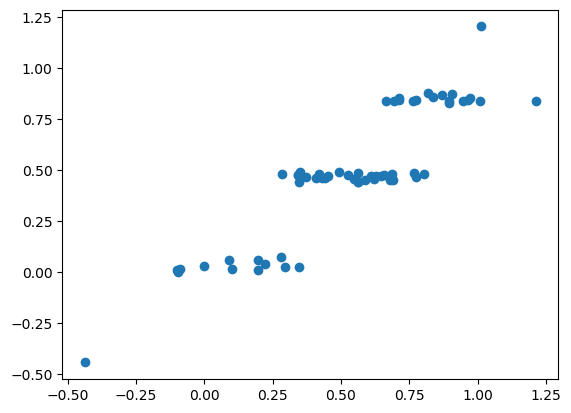

[-0.9605369174949905, 0.9160902233536503, -0.12041648079405531, -0.19939663627526505, 1.1471803354240357, 1.4579724390607671, 0.676606577191166, -0.5578810312092743, 1.818795242995876, -0.8527812128804855, -2.0040786196822813, 0.8924999336927009, -0.7849778473712878, -0.5360996254570898, 0.04793602137301001, 1.0701435298783588, -2.0103881206418563, 2.24608946773455, 0.8955446442477757, 1.9559995277627014, 1.1716098045773642, -0.35815300871009814, 2.2464864241010636, 0.01850364040627861, 2.7944962669197113, 1.837092723015763, -1.1029706115440423, -0.2006773803890728, -0.2181855969693396, -1.0749452228826621, 0.5779196394566752, -0.13073690695267182, -0.06948584431935245, nan, 0.716984615152402, 9.424587482196227, -0.7794586503432073, -0.2262817249121848, 0.2297153771753142, 2.056158765187497, 0.005709523710828779, 0.5819201912874434, -1.8040707090274148, 0.5961526745348715, -1.0427200905111107, 0.36283525224657387, -0.30979319146783846, 0.9408729619671066, 1.8782855042492068, -2.3091427

In [119]:
plt.plot(np.log10(med_li), np.log10(med_nn), 'o')
plt.show()
print([i-j for i,j in zip(med_li, med_nn)])

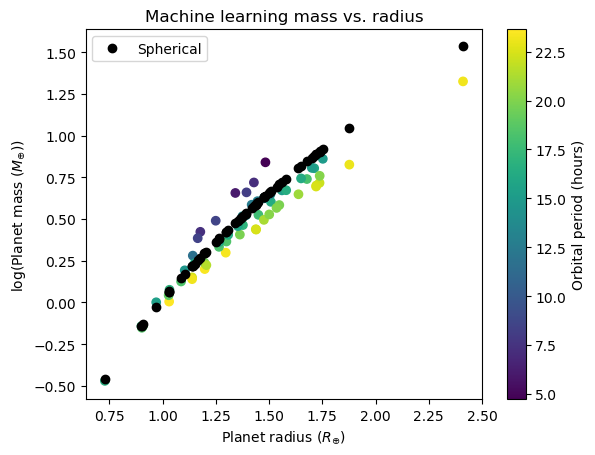

In [120]:
plt.scatter(meanearthradii, np.log10(med_ml), c = per2)
plt.plot(meanearthradii, np.log10(med_sph), 'ko',label = "Spherical")
plt.legend()
cbar = plt.colorbar()
cbar.set_label("Orbital period (hours)")
plt.xlabel("Planet radius ($R_{\oplus}$)")
plt.ylabel("log(Planet mass ($M_{\oplus}$))")
plt.title("Machine learning mass vs. radius")
plt.show()

Make a list of planets that have negative residuals. Make some plots and see if anythings pops out.

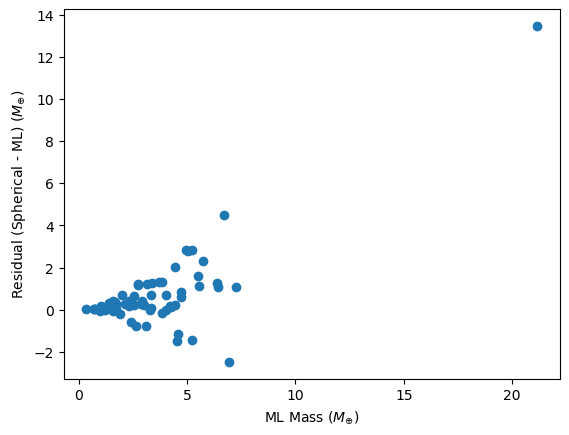

In [121]:
plt.plot(ml_masses, residuals, 'o')
plt.xlabel("ML Mass ($M_{\oplus}$)")
plt.ylabel("Residual (Spherical - ML) ($M_{\oplus}$)")
plt.show()

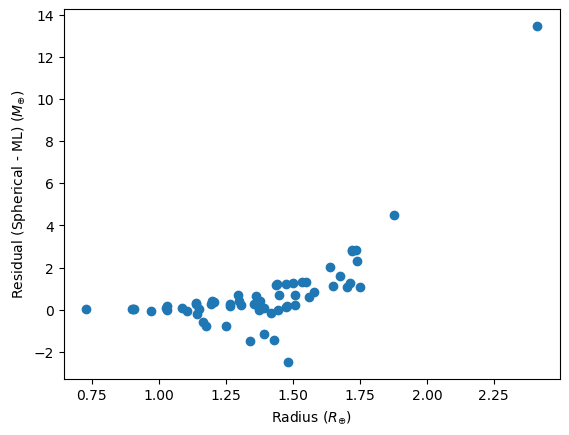

In [65]:
plt.plot(meanearthradii, residuals, 'o')
plt.xlabel("Radius ($R_{\oplus}$)")
plt.ylabel("Residual (Spherical - ML) ($M_{\oplus}$)")
plt.show()

#### Regenerating plots

In [66]:
earth_masses, up_err_earth,down_err_earth = np.loadtxt("earth_masses.txt", unpack = True)
merc_masses, up_err_merc,down_err_merc = np.loadtxt("mercury_masses.txt", unpack = True)
massrand, up_err_rand,down_err_rand = np.loadtxt("random_masses.txt", unpack = True)

print(len(earth_masses), len(merc_masses), len(rand_masses))



NameError: name 'rand_masses' is not defined

In [ ]:
randsamples = np.loadtxt("random_mass_samples")
mercurysamples = np.loadtxt("mercury_mass_samples")
earthsamples = np.loadtxt("mercury_mass_samples")
print(len(rsamples), len(msamples), len(esamples))

In [ ]:
radbins = [0.5,(1/np.sqrt(2)),1,np.sqrt(2),2,2*np.sqrt(2),4]
massbins = [0.5,1,2,4,8,16,32]
perbins = [4,4*(6**0.25),4*np.sqrt(6),4*(6**0.75),24]

massarray = np.zeros((len(massbins)-1,len(perbins)-1))

massbinsflip = np.flip(massbins,0)

f = [(adivr[i]/numstars[i]) for i in range(0,len(kepid))]
f2 = [(1/numstars[i]) for i in range(0,len(kepid))]

## sum occurrence rate in bins

earthmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))
earthfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))

for i in range(len(massrand)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
                massarray[k][j] += (f[i])
                
kep10sumearth = 0
kep78sumearth = 0
earthweighted78sum = 0
earthweighted10sum = 0
eartharray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(earthperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*earthperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= earthsamples[i] >= massbinsflip[k+1]):
                eartharray[k][j] += (f[per.index(earthperiodsamples[i])])/1000
                earthmasstransitarray[k][j] += (f2[per.index(earthperiodsamples[i])])/1000
                earthfreqarray[k][j] += 1/1000
                if (earthperiodsamples[i] == kep10per):
                    kep10sumearth += (f[per.index(earthperiodsamples[i])])/1000
                    earthweighted10sum += ((f[per.index(earthperiodsamples[i])])/1000 *  dist10.pdf(earthsamples[i]))
                if (earthperiodsamples[i] == kep78per):
                    kep78sumearth += (f[per.index(earthperiodsamples[i])])/1000
                    earthweighted78sum += ((f[per.index(earthperiodsamples[i])])/1000 *  dist78.pdf(earthsamples[i]))

                
kep10summerc = 0    
kep78summerc = 0 
mercweighted78sum = 0
mercweighted10sum = 0
mercuryarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(mercperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*mercperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= mercurysamples[i] >= massbinsflip[k+1]):
                mercuryarray[k][j] += (f[per.index(mercperiodsamples[i])])/1000
                mercmasstransitarray[k][j] += (f2[per.index(mercperiodsamples[i])])/1000
                mercfreqarray[k][j] += 1/1000
                if (mercperiodsamples[i] == kep10per):
                    kep10summerc += (f[per.index(mercperiodsamples[i])])/1000
                    mercweighted10sum += ((f[per.index(mercperiodsamples[i])])/1000 *  dist10.pdf(mercurysamples[i]))

                if (mercperiodsamples[i] == kep78per):
                    kep78summerc += (f[per.index(mercperiodsamples[i])])/1000
                    mercweighted78sum += ((f[per.index(mercperiodsamples[i])])/1000 *  dist78.pdf(mercurysamples[i]))

    
    
earthmasssum = np.zeros(len(massbins)-1)   
mercmasssum = np.zeros(len(massbins)-1) 
masssum = np.zeros(len(massbins)-1)  

merctransitsum = np.zeros(len(massbins)-1) 
earthtransitsum = np.zeros(len(massbins)-1) 

mercfreqsum = np.zeros(len(massbins)-1) 
earthfreqsum = np.zeros(len(massbins)-1) 
for j in range(len(massbins) - 1):
    for i in range(len(perbins)-1):
        masssum[j] += massarray[j][i]*1000
        earthmasssum[j] += eartharray[j][i]*1000
        mercmasssum[j] += mercuryarray[j][i]*1000
        earthtransitsum[j] += earthmasstransitarray[i][j] * 1000
        merctransitsum[j] += mercmasstransitarray[i][j] * 1000
        mercfreqsum[j] += mercfreqarray[i][j]
        earthfreqsum[j] += earthfreqarray[i][j]
        

massticks = np.zeros(len(massbins)-1) 
for i in range(len(massbins)-1):
    massticks[i] = np.log2((massbins[i+1] + massbins[i])/2)
         

       
earthwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
earthwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if earthtransitsum[i] == 0:
        earthwilsonhigh[i] = "N=0"
        earthwilsonlow[i] = "N=0"
    else:
        n = (earthfreqsum[i])/(earthtransitsum[i])
        if n == 0:
            earthwilsonhigh[i] = "n=0"
            earthwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((earthtransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((earthtransitsum[i] - (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            earthwilsonhigh[i] = ((earthmasssum[i]/earthtransitsum[i])*high) - earthmasssum[i]
            earthwilsonlow[i] = ((earthmasssum[i]/earthtransitsum[i])*low) - earthmasssum[i]

mercwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
mercwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if merctransitsum[i] == 0:
        mercwilsonhigh[i] = "N=0"
        mercwilsonlow[i] = "N=0"
    else:
        n = (mercfreqsum[i])/(merctransitsum[i])
        if n == 0:
            mercwilsonhigh[i] = "n=0"
            mercwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((merctransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((merctransitsum[i] - (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            mercwilsonhigh[i] = ((mercmasssum[i]/merctransitsum[i])*high) - mercmasssum[i]
            mercwilsonlow[i] = ((mercmasssum[i]/merctransitsum[i])*low) - mercmasssum[i]


eartherrorup = np.zeros(len(massbins)-1)
eartherrordown = np.zeros(len(massbins)-1)
mercerrorup = np.zeros(len(massbins)-1)
mercerrordown = np.zeros(len(massbins)-1)
for i in range(len(eartherrorup)):
    if earthwilsonhigh[i] == 'N=0':
        eartherrorup[i] = 0
        eartherrordown[i] = 0
        mercerrorup[i] = 0
        mercerrordown[i] = 0
    else:
        eartherrorup[i] = earthwilsonhigh[i]
        eartherrordown[i] = -1 * earthwilsonlow[i]
        mercerrorup[i] = mercwilsonhigh[i]
        mercerrordown[i] = -1 * mercwilsonlow[i]

# for o in range(0,49):
#     massarray = np.zeros((len(massbins)-1,len(perbins)-1))
#     massrand = []
#     for j in meanearthradii:
#         randomcmf = np.random.normal(0.33,0.1)
#         while (randomcmf <= 0):
#             randomcmf = np.random.normal(0.33,0.1)
#         try:
#             massrand.append(getmass((getpcmb(j, randomcmf), getpmaxhat(j, randomcmf))))
#         except:
#             print("couldn't interpolate", randomcmf)
#     for i in range(len(massrand)):
#         for j in range(len(perbins)-1):
#             for k in range(len(massbins)-1):
#                 if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
#                     massarray[k][j] += (f[i])
#     masssum = np.zeros(len(massbins)-1)  
#     for j in range(len(massbins) - 1):
#         for i in range(len(perbins)-1):
#             masssum[j] += massarray[j][i]*1000
#     plt.plot(massticks,np.flip(masssum,0), color = 'g', alpha = 0.2)
plt.plot(massticks,np.flip(masssum,0), color = 'g',label = 'Random CMF', alpha = 0.2)
plt.plot(massticks,np.flip(earthmasssum,0), label = 'Earth-like', linewidth = 2.5)
plt.plot(massticks,np.flip(mercmasssum,0), label = 'Mercury-like', linewidth = 2.5)

plt.errorbar(massticks,np.flip(mercmasssum,0), yerr = np.stack((mercerrorup,mercerrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.errorbar(massticks,np.flip(earthmasssum,0), yerr = np.stack((eartherrorup,eartherrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.xlabel('Planet Mass ($M_{ \oplus}$)')
plt.ylabel('Number of planets per thousand stars')
plt.xticks([-1,0,1,2,3,4,5], [0.5,1,2,4,8,16,32])
plt.legend()

array = np.zeros((len(massbins)-1,len(perbins)-1))
freqarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(randperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= randmasssamples[i] >= massbinsflip[k+1]):
                array[k][j] += (f[per.index(randperiodsamples[i])])/1000
                freqarray[k][j] += 1

import seaborn as sns


fig, ax = plt.subplots()


ax = sns.heatmap(1000*eartharray, annot = True, annot_kws={"size": 14})
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([4,6.3,9.8,15.3,24], fontsize = 14)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels([0.5,1,2,4,8,16,32], fontsize = 14)
cbar = ax.collections[0].colorbar
cbar.set_label('Planet Occurence - # planets per 1000 stars', fontsize = 14)
plt.xlabel("Orbital Period (hours)", fontsize = 16)
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 16)

plt.show()

In [395]:
per

[0.1973335,
 0.48765719,
 0.76669043,
 0.35500753,
 0.25255594,
 0.74092963,
 0.6364249,
 0.30598391,
 0.30160087,
 0.97730809,
 0.92831093,
 0.57103885,
 0.81316598,
 0.89638348,
 0.75445863,
 0.86838702,
 0.67933587,
 0.62628076,
 0.70862545,
 0.88183821,
 0.93512027,
 0.675652,
 0.92103467,
 0.97486662,
 0.82628363,
 0.56785704,
 0.66502914,
 0.7165313,
 0.76401932,
 0.63400313,
 0.60992303,
 0.67737578,
 0.63816268,
 0.96896529,
 0.96852469,
 0.96286621,
 0.35251639,
 0.76985432,
 0.70194345,
 0.55884253,
 0.69384332,
 0.82715274,
 0.57736948,
 0.66308666,
 0.68920948,
 0.66407444,
 0.76295078,
 0.63133223,
 0.92785963,
 0.93846561,
 0.66931017,
 0.9849389,
 0.8399616,
 0.8374906,
 0.59701811,
 0.76486301,
 0.52417582,
 0.78916057,
 0.341842,
 0.93875053,
 0.84338039,
 0.53835457]

In [396]:
meanearthmasses

[4.424815197163635,
 1.6991286542274873,
 2.713264067453435,
 2.327410550594495,
 3.0349987937864062,
 4.060197010911225,
 3.234392410108265,
 1.8882798720523926,
 3.8217311662147058,
 1.9999067668694719,
 3.922134632727354,
 3.290115095363375,
 1.9930800696896687,
 2.041069073921702,
 7.111189854870369,
 6.485507207361181,
 4.709951196147637,
 8.351282496240868,
 3.3083775226583874,
 4.349591712988995,
 1.6812680959787918,
 6.678283415266144,
 8.048790041258025,
 2.6895809949397527,
 5.147445759206458,
 4.3733591176682935,
 1.7459973590656606,
 0.7339186148129471,
 0.7559671619718613,
 5.284051934649986,
 1.494862723674181,
 2.7754429794292816,
 0.9555585011158505,
 34.60479146806121,
 1.6806959323113695,
 11.175766857877989,
 1.8230066173348092,
 0.7395303414730685,
 1.1839707208159929,
 4.34887812841494,
 0.35623288371226014,
 3.1995659993357224,
 4.686170169704227,
 7.6528577906394695,
 5.568243931308395,
 3.1274489427830447,
 2.4469956418032135,
 7.475509605031213,
 7.808665398692

In [403]:
np.log10(per2)

array([0.67541206, 1.06832587, 1.26483128, 0.93044881, 0.78256883,
       1.2499882 , 1.1839584 , 0.86590983, 0.85964383, 1.37024274,
       1.34790471, 1.1368769 , 1.29039044, 1.33270509, 1.25784667,
       1.31892457, 1.21229579, 1.17698031, 1.23062799, 1.32560015,
       1.35107871, 1.20993431, 1.34448722, 1.36915644, 1.29734039,
       1.13445026, 1.20305192, 1.23544641, 1.26331558, 1.18230264,
       1.16548627, 1.21104091, 1.18514264, 1.36651946, 1.36632194,
       1.36377719, 0.92739056, 1.26661979, 1.22651337, 1.12750069,
       1.22147265, 1.29779695, 1.14166506, 1.20178153, 1.21856248,
       1.20242801, 1.26270776, 1.1804692 , 1.34769352, 1.3526296 ,
       1.20583867, 1.37362053, 1.30447067, 1.30319118, 1.15619875,
       1.2637949 , 1.09968822, 1.27737662, 0.91403666, 1.35276144,
       1.30623474, 1.11127965])

In [404]:
a_in_km = np.array([3313469.7957913587, 2584036.317121426, 2714294.2152613997,
                    1772884.159940001, 2143068.1879994078, 3543767.5210273163,
                    2801799.4278695458, 3630484.6636752333, 1144529.225037405,
                    2441145.36062295, 2621737.6457685567, 2235937.443659193,
                    2677255.9007173027, 4120907.1268979167, 6319991.856759419,
                    2954889.5548668257, 2654737.4137539663, 2296263.1825336064,
                    2302558.7957747364, 3040407.297719784, 4138341.6071832594,
                    2031672.7723260163, 3075898.019511547, 2729229.8502186122,
                    5561909.691438591, 2189436.0060557513, 2155860.538114208,
                    5832289.402442471, 2608687.1633906933, 2820931.203554932,
                    2147080.4062184496, 2672585.9754614686, 2336192.310409733,
                    6722232.192411267, 3794308.6598805953, 3098016.3572701863,
                    1600442.7809916383, 3222482.3200247292, 3893544.505952112,
                    2977680.71811518, 2377906.207632494, 2566034.9218412396,
                    1899308.2983503554, 2774016.27310899, 2367026.1759551046,
                    2713272.7674144977, 3349766.080054444, 2278494.07623878,
                    2558266.5178632326, 3468061.23860263, 2280928.675453437,
                    2785569.5815232927, 2474823.19717925, 2568310.861173996,
                    4526431.5694433525, 2819000.8881157264, 2907463.153159022,
                    2795016.5341381603, 1445454.9633131241, 3421992.945103477,
                    2385987.0813516434, 1849302.9843809663])

In [ ]:
a_in_m = a_in_km * (10**3)

In [ ]:
M_stars = [((4*(np.pi**2)*(a**3)) / ((6.67e-11)*(T**2)))/(1.989e30) for a, T in zip(a_in_m, (per2 * 3600))]

In [420]:
np.log10(M_stars)



array([8.68362405, 7.57384321, 7.24490731, 7.35874259, 7.90156943,
       7.62201838, 7.44799344, 8.42167328, 6.93019212, 6.89589457,
       7.0335574 , 7.24822427, 7.17588789, 7.65316743, 8.36005533,
       7.24737375, 7.32107225, 7.20270348, 7.09897533, 7.27119411,
       7.62192071, 6.97729178, 7.24854048, 7.04340657, 8.11459014,
       7.22569538, 7.06835727, 8.3002235 , 7.19623396, 7.46017132,
       7.1381715 , 7.33231236, 7.2088396 , 8.22310072, 7.47835321,
       7.21929586, 7.23153846, 7.46493116, 7.79160781, 7.64023212,
       7.15923798, 7.1057929 , 7.02605539, 7.39936307, 7.15908333,
       7.36922347, 7.52322704, 7.18560443, 7.00204944, 7.38860018,
       7.1362569 , 7.06110009, 7.04529031, 7.09615952, 8.1284695 ,
       7.29629496, 7.66476533, 7.25799902, 7.12553949, 7.37091358,
       6.9941339 , 7.05206404])

In [503]:
np.min(np.log10(M_stars))

6.895894570797139

In [422]:
np.min(np.log10(M_stars))

NameError: name 'T' is not defined

In [ ]:
koi

In [ ]:
M_star2 = (((a_in_m) / (1.496e11))**3) / (np.array(per) / 365)**2

In [551]:
M_star2

array([37.17391992,  2.8870714 ,  1.3536975 ,  1.75936885,  6.14021732,
        3.22576476,  2.16076606, 20.33703275,  0.65585288,  0.6060506 ,
        0.8320927 ,  1.36407605,  1.15478783,  3.46562638, 17.64694951,
        1.36140725,  1.61319388,  1.22833774,  0.96736338,  1.43816403,
        3.22503935,  0.73098101,  1.36506958,  0.85117897, 10.02777197,
        1.29511904,  0.90151215, 15.37580326,  1.21017526,  2.22221272,
        1.05873144,  1.65549043,  1.24581602, 12.87404539,  2.31722138,
        1.27617483,  1.31266159,  2.24670202,  4.76674727,  3.363926  ,
        1.11135367,  0.9826689 ,  0.81784254,  1.93186769,  1.11095801,
        1.80234442,  2.56945696,  1.18091527,  0.77386241,  1.88457964,
        1.05407428,  0.8865728 ,  0.85487894,  0.96111163, 10.35341959,
        1.52373439,  3.55942331,  1.39512569,  1.02838042,  1.80937209,
        0.7598856 ,  0.8683171 ])

In [552]:
np.savetxt("USPHostMasses.txt", M_star2)

In [432]:
np.log10(M_star2)


array([ 1.57023836,  0.46045752,  0.13152163,  0.2453569 ,  0.78818374,
        0.50863269,  0.33460775,  1.30828759, -0.18319357, -0.21749112,
       -0.07982829,  0.13483858,  0.0625022 ,  0.53978174,  1.24666964,
        0.13398806,  0.20768657,  0.0893178 , -0.01441036,  0.15780842,
        0.50853502, -0.1360939 ,  0.13515479, -0.06997911,  1.00120445,
        0.11230969, -0.04502841,  1.18683781,  0.08284827,  0.34678563,
        0.02478581,  0.21892668,  0.09545391,  1.10971504,  0.36496753,
        0.10591018,  0.11815278,  0.35154548,  0.67822213,  0.52684643,
        0.04585229, -0.00759279, -0.0873303 ,  0.28597738,  0.04569765,
        0.25583779,  0.40984135,  0.07221874, -0.11133625,  0.2752145 ,
        0.02287122, -0.0522856 , -0.06809538, -0.01722617,  1.01508382,
        0.18290927,  0.55137964,  0.14461334,  0.0121538 ,  0.25752789,
       -0.11925179, -0.06132165])

In [505]:
print(np.min(np.log10(M_star2)))
print(np.max(np.log10(M_star2)))

-0.2174911171272732
1.5702383590092814


In [ ]:
short_periods = np.where(np.array(per2) < 10)[0]

In [444]:
for i in short_periods:
    print(np.log10(per2[i]), np.log10(M_star2[i]))

0.6754120605174803 1.5702383590092814
0.9304488066054785 0.24535689785974107
0.7825688290873372 0.7881837424189766
0.8659098316509135 1.3082875879451885
0.8596438316800795 -0.1831935716118963
0.9273905557229403 0.11815277590697605
0.914036662435861 0.012153801009212886


Okay, so the graph doesn't reach for the first or fourth one, but I don't know what's happening with those. For the second one:

In [502]:
print("new mass: ", 10**1.44)
print("old mass: ", meanearthmasses[1])

new mass:  27.542287033381662
old mass:  1.6991286542274873


For the 3rd one

In [497]:
10**1.20

15.848931924611133

For the 5th one:

In [498]:
10**0.8

6.309573444801933

for the 6th one:

In [450]:
10**1.52

33.11311214825911

In [451]:
10**1.28

19.054607179632473

In [454]:
short_periods

array([ 0,  3,  4,  7,  8, 36, 58])

In [455]:
meanearthmasses[3]

2.327410550594495

In [456]:
meanearthmasses[4]

3.0349987937864062

In [458]:
meanearthmasses[8]

3.8217311662147058

In [459]:
meanearthmasses[36]

1.8230066173348092

In [460]:
meanearthmasses[58]

3.437247402436168

In [469]:
omegas = [(2 * np.pi) / (i * 3600) for i in per2]
omegas

[0.00036852360175251744,
 0.00014912535620859068,
 9.485191065503505e-05,
 0.000204846506118984,
 0.00028794433489242184,
 9.814974219134737e-05,
 0.00011426650994709729,
 0.00023766626214571346,
 0.00024112016708184692,
 7.441057012679636e-05,
 7.833803288993957e-05,
 0.00012735044588722886,
 8.943076069959345e-05,
 8.112828246949665e-05,
 9.638971478983599e-05,
 8.374382676335996e-05,
 0.00010704874477838246,
 0.0001161173339676448,
 0.00010262410440724419,
 8.246643357224269e-05,
 7.776759257547738e-05,
 0.00010763240864591594,
 7.895691067354759e-05,
 7.459692503004195e-05,
 8.801100436472448e-05,
 0.0001280640144329819,
 0.00010935167768201917,
 0.00010149180107893457,
 9.518352515801615e-05,
 0.00011470298603483298,
 0.00011923152363410576,
 0.0001073585066274888,
 0.00011395535095601391,
 7.505124581545165e-05,
 7.508538803118214e-05,
 7.552664265415484e-05,
 0.00020629410214495383,
 9.446209533049109e-05,
 0.00010360101254086834,
 0.0001301297740643154,
 0.0001048104810844477,


In [470]:
short_periods

array([ 0,  3,  4,  7,  8, 36, 58])

In [479]:
for i in short_periods:
    print(omegas[i]*(10**4))

3.6852360175251744
2.04846506118984
2.879443348924218
2.3766626214571347
2.4112016708184694
2.0629410214495385
2.127358609136104


for this one, 0.08

In [472]:
newrad = ((1 + 0.08)**(1/3)) * meanearthradii[0]
newrad

1.5213924683877782

In [473]:
meanearthradii[0]

1.4828595214497735

In [474]:
getmass((getpcmb(newrad, 0.33), getpmaxhat(newrad, 0.33)))

array(4.85240069)

In [475]:
meanearthmasses[0]

4.424815197163635

In [527]:
squishmasses = []

In [540]:
def getnewmass(index, distortion):
    newrad = ((1 + distortion)**(1/3)) * meanearthradii[index]
    newmass = getmass((getpcmb(newrad, 0.33), getpmaxhat(newrad, 0.33)))
    print("New mass: ", newmass)
    print("Old mass: ", meanearthmasses[index])
    print("% difference: ", ((meanearthmasses[index] - newmass) / meanearthmasses[index]) * 100)
    squishmasses.append(newmass)
    return newmass

In [529]:
getnewmass(0, 0.08)

New mass:  4.852400693380432
Old mass:  4.424815197163635
% difference:  -9.663352641052311


In [530]:
getnewmass(short_periods[1], 0.04)

New mass:  2.455076608084992
Old mass:  2.327410550594495
% difference:  -5.4853260615273625


In [531]:
getnewmass(short_periods[2], 0.04)

New mass:  3.1705056321431595
Old mass:  3.0349987937864062
% difference:  -4.464806992153612


In [532]:
getnewmass(short_periods[3], 0.04)

New mass:  1.9725794733792292
Old mass:  1.8882798720523926
% difference:  -4.464359472052757


In [533]:
getnewmass(short_periods[4], 0.04)

New mass:  4.035721521116984
Old mass:  3.8217311662147058
% difference:  -5.599304231391772


In [534]:
getnewmass(short_periods[5], 0.04)

New mass:  1.905541820454548
Old mass:  1.8230066173348092
% difference:  -4.5274220255109805


In [535]:
getnewmass(short_periods[6], 0.04)

New mass:  3.6373483132997833
Old mass:  3.437247402436168
% difference:  -5.821545191125681


In [536]:
squishmasses

[array(4.85240069),
 array(2.45507661),
 array(3.17050563),
 array(1.97257947),
 array(4.03572152),
 array(1.90554182),
 array(3.63734831)]

In [537]:
masses_w_td = np.copy(meanearthmasses)

In [538]:
for i, j in enumerate(short_periods):
    ## i is index in short_periods array
    ## j is index in masses 
    masses_w_td[j] = squishmasses[i]

In [539]:
masses_w_td

array([ 4.85240069,  1.69912865,  2.71326407,  2.45507661,  3.17050563,
        4.06019701,  3.23439241,  1.97257947,  4.03572152,  1.99990677,
        3.92213463,  3.2901151 ,  1.99308007,  2.04106907,  7.11118985,
        6.48550721,  4.7099512 ,  8.3512825 ,  3.30837752,  4.34959171,
        1.6812681 ,  6.67828342,  8.04879004,  2.68958099,  5.14744576,
        4.37335912,  1.74599736,  0.73391861,  0.75596716,  5.28405193,
        1.49486272,  2.77544298,  0.9555585 , 34.60479147,  1.68069593,
       11.17576686,  1.90554182,  0.73953034,  1.18397072,  4.34887813,
        0.35623288,  3.199566  ,  4.68617017,  7.65285779,  5.56824393,
        3.12744894,  2.44699564,  7.47550961,  7.8086654 ,  3.94176277,
        2.46144062,  1.17763371,  8.06238695,  5.00407944,  3.41875724,
        1.40401441,  3.70470456,  1.16942615,  3.63734831,  7.7912594 ,
        4.62352615,  4.01304764])

len massrand 62


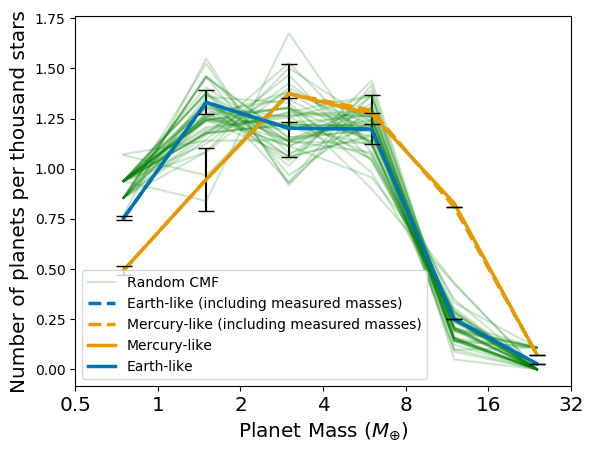

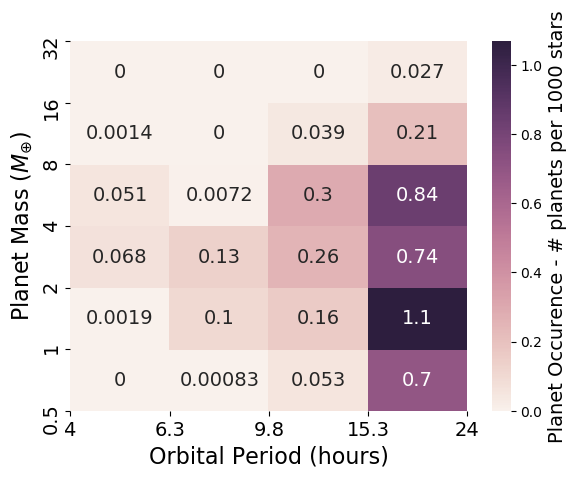

In [543]:

earthsamples = []
earthperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('EarthlikeMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             earthperiodsamples.append(float(per[kepid.index(kepid2)]))
         earthsamples = earthsamples + samplelist
         rownum += 1

mercurysamples = []
mercperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('MercuryLikeMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             mercperiodsamples.append(float(per[kepid.index(kepid2)]))
         mercurysamples = mercurysamples + samplelist
         rownum += 1

randsamples = []
massrand = []
randperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('RandomCMFMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             randperiodsamples.append(float(per[kepid.index(kepid2)]))
         massrand.append(np.percentile(list1, 50))
         randsamples = randsamples + samplelist
         rownum += 1

print("len massrand", len(massrand))

radbins = [0.5,(1/np.sqrt(2)),1,np.sqrt(2),2,2*np.sqrt(2),4]
massbins = [0.5,1,2,4,8,16,32]
perbins = [4,4*(6**0.25),4*np.sqrt(6),4*(6**0.75),24]

massarray = np.zeros((len(massbins)-1,len(perbins)-1))

massbinsflip = np.flip(massbins,0)

f = [(adivr[i]/numstars[i]) for i in range(0,len(kepid))]
f2 = [(1/numstars[i]) for i in range(0,len(kepid))]

## sum occurrence rate in bins

earthmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))
earthfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))

for i in range(len(massrand)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
                massarray[k][j] += (f[i])
                
eartharray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(earthperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*earthperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= earthsamples[i] >= massbinsflip[k+1]):
                earthmasstransitarray[k][j] += (f2[per.index(earthperiodsamples[i])])/1000
                earthfreqarray[k][j] += 1/1000
                if (earthperiodsamples[i] == kep10per):
                    eartharray[k][j] += ((f[per.index(earthperiodsamples[i])])/1000) * dist10.pdf(earthsamples[i]) * earth10norm
                elif (earthperiodsamples[i] == kep78per):
                    eartharray[k][j] += ((f[per.index(earthperiodsamples[i])])/1000) * dist78.pdf(earthsamples[i]) * earth78norm
                else:
                    eartharray[k][j] += (f[per.index(earthperiodsamples[i])])/1000
                          
mercuryarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(mercperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*mercperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= mercurysamples[i] >= massbinsflip[k+1]):
                mercmasstransitarray[k][j] += (f2[per.index(mercperiodsamples[i])])/1000
                mercfreqarray[k][j] += 1/1000
                if (mercperiodsamples[i] == kep10per):
                    mercuryarray[k][j] += (f[per.index(mercperiodsamples[i])])/1000 * dist10.pdf(mercurysamples[i]) * merc10norm
                elif (mercperiodsamples[i] == kep78per):
                    mercuryarray[k][j] += (f[per.index(mercperiodsamples[i])])/1000 * dist78.pdf(mercurysamples[i]) * merc78norm
                else:
                    mercuryarray[k][j] += (f[per.index(mercperiodsamples[i])])/1000

    
    
earthmasssum2 = np.zeros(len(massbins)-1)   
mercmasssum2 = np.zeros(len(massbins)-1) 
masssum = np.zeros(len(massbins)-1)  

merctransitsum = np.zeros(len(massbins)-1) 
earthtransitsum = np.zeros(len(massbins)-1) 

mercfreqsum = np.zeros(len(massbins)-1) 
earthfreqsum = np.zeros(len(massbins)-1) 
for j in range(len(massbins) - 1):
    for i in range(len(perbins)-1):
        masssum[j] += massarray[j][i]*1000
        earthmasssum2[j] += eartharray[j][i]*1000
        mercmasssum2[j] += mercuryarray[j][i]*1000
        earthtransitsum[j] += earthmasstransitarray[i][j] * 1000
        merctransitsum[j] += mercmasstransitarray[i][j] * 1000
        mercfreqsum[j] += mercfreqarray[i][j]
        earthfreqsum[j] += earthfreqarray[i][j]
        

massticks = np.zeros(len(massbins)-1) 
for i in range(len(massbins)-1):
    massticks[i] = np.log2((massbins[i+1] + massbins[i])/2)
         

       
earthwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
earthwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if earthtransitsum[i] == 0:
        earthwilsonhigh[i] = "N=0"
        earthwilsonlow[i] = "N=0"
    else:
        n = (earthfreqsum[i])/(earthtransitsum[i])
        if n == 0:
            earthwilsonhigh[i] = "n=0"
            earthwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((earthtransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((earthtransitsum[i] - (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            earthwilsonhigh[i] = ((earthmasssum2[i]/earthtransitsum[i])*high) - earthmasssum2[i]
            earthwilsonlow[i] = ((earthmasssum2[i]/earthtransitsum[i])*low) - earthmasssum2[i]

mercwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
mercwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if merctransitsum[i] == 0:
        mercwilsonhigh[i] = "N=0"
        mercwilsonlow[i] = "N=0"
    else:
        n = (mercfreqsum[i])/(merctransitsum[i])
        if n == 0:
            mercwilsonhigh[i] = "n=0"
            mercwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((merctransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((merctransitsum[i] - (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            mercwilsonhigh[i] = ((mercmasssum2[i]/merctransitsum[i])*high) - mercmasssum2[i]
            mercwilsonlow[i] = ((mercmasssum2[i]/merctransitsum[i])*low) - mercmasssum2[i]


eartherrorup = np.zeros(len(massbins)-1)
eartherrordown = np.zeros(len(massbins)-1)
mercerrorup = np.zeros(len(massbins)-1)
mercerrordown = np.zeros(len(massbins)-1)
for i in range(len(eartherrorup)):
    if earthwilsonhigh[i] == 'N=0':
        eartherrorup[i] = 0
        eartherrordown[i] = 0
        mercerrorup[i] = 0
        mercerrordown[i] = 0
    else:
        eartherrorup[i] = earthwilsonhigh[i]
        eartherrordown[i] = -1 * earthwilsonlow[i]
        mercerrorup[i] = mercwilsonhigh[i]
        mercerrordown[i] = -1 * mercwilsonlow[i]

q = plt.figure()        
mygold = (.9, .6, 0)
for o in range(0,49):
    massarray = np.zeros((len(massbins)-1,len(perbins)-1))
    massrand = []
    for j in meanearthradii:
        randomcmf = np.random.normal(0.33,0.1)
        while (randomcmf <= 0):
            randomcmf = np.random.normal(0.33,0.1)
        try:
            massrand.append(getmass((getpcmb(j, randomcmf), getpmaxhat(j, randomcmf))))
        except:
            print("couldn't interpolate", randomcmf)
    for i in range(len(massrand)):
        for j in range(len(perbins)-1):
            for k in range(len(massbins)-1):
                if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
                    massarray[k][j] += (f[i])
    masssum = np.zeros(len(massbins)-1)  
    for j in range(len(massbins) - 1):
        for i in range(len(perbins)-1):
            masssum[j] += massarray[j][i]*1000
    plt.plot(massticks,np.flip(masssum,0), color = 'g', alpha = 0.2)
plt.plot(massticks,np.flip(masssum,0), color = 'g',label = 'Random CMF', alpha = 0.2)
plt.plot(massticks,np.flip(earthmasssum2,0), label = 'Earth-like (including measured masses)', color = myblue, linestyle='dashed', linewidth = 2.5)
plt.plot(massticks,np.flip(mercmasssum2,0), label = 'Mercury-like (including measured masses)', color = mygold, linestyle='dashed', linewidth = 2.5)
plt.plot(massticks,np.flip(mercmasssum,0), label = 'Mercury-like', color = mygold, linewidth = 2.5)
plt.plot(massticks,np.flip(earthmasssum,0), label = 'Earth-like', color = myblue, linewidth = 2.5)



plt.errorbar(massticks,np.flip(mercmasssum2,0), yerr = np.stack((mercerrorup,mercerrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.errorbar(massticks,np.flip(earthmasssum2,0), yerr = np.stack((eartherrorup,eartherrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.xlabel('Planet Mass ($M_{ \oplus}$)', fontsize = 'x-large')
plt.ylabel('Number of planets per thousand stars', fontsize = 'x-large')
plt.xticks([-1,0,1,2,3,4,5], [0.5,1,2,4,8,16,32], fontsize = 'x-large')
plt.legend()
q.savefig("PosterFig5.pdf", bbox_inches = "tight")

array = np.zeros((len(massbins)-1,len(perbins)-1))
freqarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(randperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= randmasssamples[i] >= massbinsflip[k+1]):
                array[k][j] += (f[per.index(randperiodsamples[i])])/1000
                freqarray[k][j] += 1

import seaborn as sns


fig, ax = plt.subplots()


ax = sns.heatmap(1000*eartharray, annot = True, annot_kws={"size": 14})
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([4,6.3,9.8,15.3,24], fontsize = 14)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels([0.5,1,2,4,8,16,32], fontsize = 14)
cbar = ax.collections[0].colorbar
cbar.set_label('Planet Occurence - # planets per 1000 stars', fontsize = 14)
plt.xlabel("Orbital Period (hours)", fontsize = 16)
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 16)

plt.show();

In [544]:
print(koi)

[0, 4144, 2393, 0, 4430, 2880, 3032, 0, 0, 3145, 1202, 2119, 2202, 3065, 2607, 2708, 2668, 2250, 191, 2886, 2753, 2852, 1688, 1128, 2571, 1367, 2756, 2925, 1360, 2817, 4325, 1150, 577, 3106, 2517, 2716, 2874, 2281, 4207, 2735, 2079, 2548, 2409, 2493, 1169, 2589, 4366, 1300, 1428, 1655, 1442, 2492, 1510, 72, 4595, 3009, 4002, 2742, 4441, 3867, 2694, 1875]


In [545]:
len(koi)

62

In [546]:
per

[0.1973335,
 0.48765719,
 0.76669043,
 0.35500753,
 0.25255594,
 0.74092963,
 0.6364249,
 0.30598391,
 0.30160087,
 0.97730809,
 0.92831093,
 0.57103885,
 0.81316598,
 0.89638348,
 0.75445863,
 0.86838702,
 0.67933587,
 0.62628076,
 0.70862545,
 0.88183821,
 0.93512027,
 0.675652,
 0.92103467,
 0.97486662,
 0.82628363,
 0.56785704,
 0.66502914,
 0.7165313,
 0.76401932,
 0.63400313,
 0.60992303,
 0.67737578,
 0.63816268,
 0.96896529,
 0.96852469,
 0.96286621,
 0.35251639,
 0.76985432,
 0.70194345,
 0.55884253,
 0.69384332,
 0.82715274,
 0.57736948,
 0.66308666,
 0.68920948,
 0.66407444,
 0.76295078,
 0.63133223,
 0.92785963,
 0.93846561,
 0.66931017,
 0.9849389,
 0.8399616,
 0.8374906,
 0.59701811,
 0.76486301,
 0.52417582,
 0.78916057,
 0.341842,
 0.93875053,
 0.84338039,
 0.53835457]

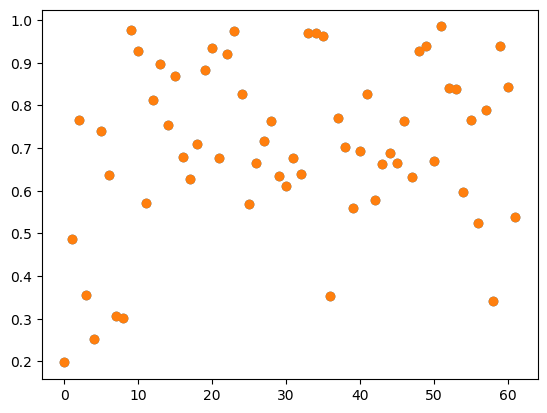

In [548]:
plt.plot(per, 'o')
plt.show()